# Santander Customer Satisfaction

This is my second Kaggle competition. After finishing the Titanic ML Competition. In this dataset I mainly focus on different Feature Selection Methods. 

The aim of the dataset is to find out which customers are happy customers.

We are provided with an anonymized dataset containing a large number of numeric variables. The "TARGET" column is the variable to predict. It equals 1 for unsatisfied customers and 0 for satisfied customers.

My other notebooks can be found [here](https://github.com/OlafKocanda/Python)

Thanks to 
* https://www.kaggle.com/cast42/exploring-features  
* https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
* https://www.kaggle.com/prashant111/a-reference-guide-to-feature-selection-methods#2.-Filter-Methods-

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import gc #importing garbage collector


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

SEED = 42
#Pandas - Displaying more rorws and columns
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def my_df_summary(data):
    '''Own summary function'''
    try:
        dat = data.copy()
        Q1 = dat.quantile(0.25)
        Q3 = dat.quantile(0.75)
        IQR = Q3 - Q1        
    
        df = pd.DataFrame([dat.sum(), dat.min(), dat.max(), ((dat < (Q1 - 1.5 * IQR)) | (dat > (Q3 + 1.5 * IQR))).sum(), dat.mean(), dat.std(), dat.median(), dat.count(), dat.isna().sum(), dat.nunique(), dat.dtypes],
                     index=['Summe','Minimum', 'Maximum', 'Ausreißer', 'Mittelwert', 'Stand. Abw.', 'Median', 'Anzahl', '#NA', '#Uniques', 'dtypes'])        
        print('In total there are {} rows with {} variables in the dataset.'.format(len(data),(len(data.columns))))

        return df
    except:
        print('A summary of the dataset was not possible.')
        return data

In [4]:
def plot_num(df):
    try:

        '''Function for Plotting all numeric columns (histograms and boxplots) for df'''
        fig = plt.figure(figsize=(20,50))

        df_plot = df.select_dtypes('number')

        for i in range(len(df_plot.columns)):
            ax = int(i*2)+1
            ax1=fig.add_subplot(9,2,ax)
            df_plot.iloc[:,i].plot(kind='hist', bins=50,ax=ax1)
            plt.title(df_plot.columns[i])
            ax = ax+1
            ax2=fig.add_subplot(9,2,ax)
            df_plot.iloc[:,i].plot(kind='box', ax=ax2)
            plt.title(df_plot.columns[i])
        return plt.show()  
    except ValueError:
        pass  # do nothing!    

In [5]:
def get_data_splits( dataframe, target_var, split_fraction=0.2):
    '''This function requires a dataframe as well as a target variable and creates equal splits for X_train, X_test, y_train, y_test'''
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(dataframe.loc[:, dataframe.columns != target_var], dataframe.loc[:,target_var],
                                                    test_size=split_fraction,
                                                    random_state=42)
    return X_train, X_test, y_train, y_test

In [6]:
def get_model_predictions(model, 
                          X_train, 
                          y_train, 
                          X_test, 
                          y_test,
                         early_stopping=50):
    ''' This function delivers predictions and fit for a predefined model. It also prints the final auc value.'''
    
    from sklearn.metrics import roc_auc_score

    fit = model.fit(X_train, y_train, early_stopping_rounds=early_stopping, eval_metric="auc",
               eval_set=[(X_train,y_train),(X_test,y_test)])

    predictions = fit.predict_proba(X_test)
       
    auc = roc_auc_score(y_test, predictions[:,1])
    print('Final auc value: '+str(auc))
    
    return (predictions, fit)

In [7]:
def get_submission(fit,
                  X_train,
                  y_train,
                  X_test,
                  target='TARGET',
                  submission_name='submission'):
    ''' This function delivers the submissions and saves it to a csv file.'''

    predictions_new = fit.predict_proba(X_test.loc[:,X_test.columns != target])
    submissions = pd.DataFrame({
        "ID": X_test.reset_index()['ID'],
        "TARGET": predictions_new[:,1]
    })
    submissions.to_csv(str(submission_name)+'.csv',index=False)
    return submissions

In [8]:
# ignoring chained assignments error
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
#!kaggle competitions download -c santander-customer-satisfaction

In [10]:
train_data = pd.read_csv(r'data\train.csv')
test_data = pd.read_csv(r'data\test.csv')
df = pd.concat([train_data, test_data],axis=0,sort=False)

In [11]:
df

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

## Data Overview

Let's start with a brief overview of the data

In [12]:
my_df_summary(df)

In total there are 151838 rows with 371 variables in the dataset.


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

In [13]:
my_df_summary(train_data)

In total there are 76020 rows with 371 variables in the dataset.


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

In [14]:
my_df_summary(test_data)

In total there are 75818 rows with 370 variables in the dataset.


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

At a first glance, we have many (371) features divided into different name groups:
* ID
* var3 & var15
* imp_ent_var16
* imp_op_var 
* ind_var
* num_var
* saldo_var
* delta_imp
* delta_num
* imp_amort
* imp_aport
* imp_var
* imp_compra
* imp_reemb
* imp_trans
* imp_venta
* ...
* TARGET

Those names only give us hints about the content. Preferably, we should not make any guesses and further proceed with data analysis excluding the 'content' / 'meaning' of the variables.

## Data Analysis

### Unique values / constant features

Moreover, it seems like we have a lot of variables with just one unique value:

In [15]:
print('Number of entries with just one unique value...')
print('1. in total: '+ str(pd.DataFrame(df.nunique().sort_values(ascending=True), columns=["nunique"])[df.nunique()==1].sum()[0]))
print('2. in training data set: '+ str(pd.DataFrame(train_data.nunique().sort_values(ascending=True), columns=["nunique"])[train_data.nunique()==1].sum()[0]))
print('3. in test data set: '+ str(pd.DataFrame(test_data.nunique().sort_values(ascending=True), columns=["nunique"])[test_data.nunique()==1].sum()[0]))

Number of entries with just one unique value...
1. in total: 34
2. in training data set: 34
3. in test data set: 45


This differs between the two datasets. In the test data set, we have 45 features (i.e. 12% of total features) with no variation in it.

Another way of doing this is using the variance threshold with 0 variance

In [16]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(train_data)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [17]:
len(train_data.columns) - sum(sel.get_support())

34

Here again, we see that 34 features have no variance.

We can take a look at the features being dropped by fit-transforming the train data with the selector, then inverse transform to get back an array with the shape of the original data.
Now for train_data all the dropped columns are filled with zeros.

In [18]:
train_data_new = sel.fit_transform(train_data)
selected_features = pd.DataFrame(sel.inverse_transform(train_data_new), index=train_data.index, columns=train_data.columns)
selected_features.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

In [19]:
selected_columns = selected_features.columns[selected_features.var() != 0]
selected_columns

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=337)

### Missing values

We do not have any **missing values** except for our TARGET variable.

In [20]:
pd.DataFrame(df.isna().sum().sort_values(ascending=False), columns=["isna"])[df.isna().sum()>0]

,isna
TARGET,75818


Here, it seems, that we have more or less equal distributions. 75818 out of 151838  (~50%) of the TARGET feature are missing.

### Missing values '-999999' - var3

A common way of filling missing values in data generation is to replace NA with '-999999'. Let's have a look in which columns this number appears.

In [21]:
# Check in what columns value -999999 appears
print ([feat for feat in df.columns if df[feat][df[feat] == -999999].shape[0] > 0])

['var3']


Let's replace it with the most common value.

In [22]:
df["var3"].mode()[0]

2

In [23]:
df['var3new']= df['var3'].replace(-999999,2)

### Categorical features

In [24]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cats = df.select_dtypes(exclude=numerics)
cats.head()

""
0
1
2
3
4


We do not have any categorical features in the dataset. All are either integers or floats.

### Balanced dataset

In [25]:
pd.DataFrame({'Absolut':train_data['TARGET'].value_counts(), 'Percentage': train_data['TARGET'].value_counts()*100/train_data.shape[0]})

,Absolut,Percentage
0,73012,96.043147
1,3008,3.956853


We have a highly unbalanced dataset with 96% of the customers being happy and only ~4% being unhappy customers.

### Correlation with target variable

In [26]:
pd.DataFrame(train_data.iloc[:,:-1].corr().iloc[-1].sort_values(ascending=False))

,var38
var38,1.000000
saldo_medio_var5_ult3,0.043077
saldo_medio_var5_ult1,0.041616
saldo_var5,0.039169
saldo_medio_var5_hace2,0.037936
saldo_medio_var5_hace3,0.031727
saldo_var30,0.028700
saldo_var13,0.023874
var36,0.021745
saldo_var13_corto,0.018770


var38 seems to be very important in terms of correlating with the TARGET variable. Let's take a closer look at this feature.

### var38

In [27]:
train_data['var38'].describe()

count    7.602000e+04
mean     1.172358e+05
std      1.826646e+05
min      5.163750e+03
25%      6.787061e+04
50%      1.064092e+05
75%      1.187563e+05
max      2.203474e+07
Name: var38, dtype: float64

In [28]:
train_data.groupby(["TARGET"])[["var38"]].mean()

,var38
TARGET,
0,117959.156918
1,99678.280590


In [29]:
train_data['var38'].value_counts()

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
                 ...  
318211.440000        1
73069.260000         1
36425.370000         1
163515.900000        1
159395.520000        1
Name: var38, Length: 57736, dtype: int64

There seems to be one very common value 117310.979016 which appears 14868 times. All other values only appear less frequently (>17 times).

Let's split this feature and create a new feature when var38 equals to 117310.979016.

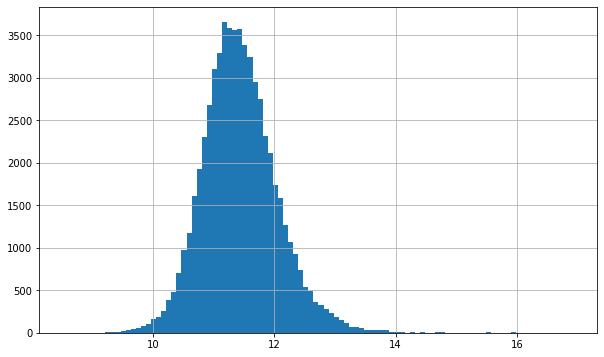

In [30]:
# Looking at the distribution, ignoring the most common value
plt.figure(figsize=(10,6))
train_data.loc[~np.isclose(train_data.var38, 117310.979016), 'var38'].map(np.log).hist(bins=100);

In [31]:
np.isclose(df.var38, 117310.979016)

array([False, False, False, ..., False,  True,  True])

In [32]:
# if the value is close to 117310 then the new variable is True otherwise false
df['var38mc'] = np.isclose(df.var38, 117310.979016)
# Converting into boolean
df['var38mc'] = list(map(int, df['var38mc']))
df['var38mc'].head()

0    0
1    0
2    0
3    0
4    1
Name: var38mc, dtype: int64

We add another variable: When var38 is 0 (i.e. not close to 117310, logvar38 is log transformed feature and zero otherwise

In [33]:
df['var38log']= 0
df['var38log'][df['var38mc']==0]=np.log(df['var38'])

### Var15

In [34]:
df['var15'].describe()

count    151838.000000
mean         33.175898
std          12.944275
min           5.000000
25%          23.000000
50%          27.000000
75%          39.000000
max         105.000000
Name: var15, dtype: float64

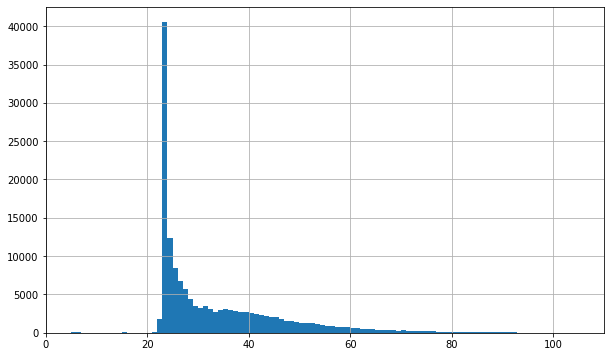

In [35]:
plt.figure(figsize=(10,6))
df['var15'].hist(bins=100)
plt.show()

In [36]:
df['var15'].mode()[0]

23

In [37]:
train_data.groupby(["TARGET"])[["var15"]].mean()

,var15
TARGET,
0,32.946406
1,39.680519


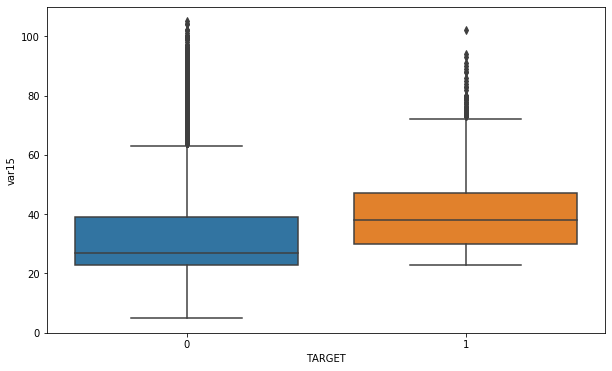

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(x='TARGET', y='var15', data=train_data)
plt.show()

var15 is supposed to be the [age of the person](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19291/data-dictionary/110414#post110414) 

We see, that people who are happy are in general younger (avg age = 33) than those who are not happy (avg age =39).

## Full Dataset

Before continuing, we should drop some columns including var3 (which is already replaced by var3new and duplicated columns.

In [39]:
df_full = df.copy()

# dropping var3 feature which is replaced by var3new
df_full.drop(['var3'],axis=1, inplace=True)


In [40]:
# splitting test and train dataset using the target column
df_test_full = df_full[df_full["TARGET"].isna()==True]
df_train_full = df_full[df_full["TARGET"].isna()==False]

In [41]:
# remove duplicated columns
duplicated = []
c = df_train_full.columns
for i in range(len(c)):
    v = df_train_full[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train_full[c[j]].values) and c[j] not in duplicated:
            duplicated.append(c[j])
            
df_train_full.drop(duplicated,axis=1, inplace=True)
df_test_full.drop(duplicated,axis=1, inplace=True)
df_full.drop(duplicated,axis=1, inplace=True)

In [42]:
len(duplicated)

62

In [43]:
gc.collect() # collecting garbage

40

# Feature Selection Methods
Besides Feature Creation, Feature Selection is crucial for the success of a Machine Learning model. Top reasons to use feature selection are (based on [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/):

* It enables the machine learning algorithm to train faster.
* It reduces the complexity of a model and makes it easier to interpret.
* It improves the accuracy of a model if the right subset is chosen.
* It reduces overfitting.

In general, there are three methods of selection:
1. **Filter Methods**: The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable.
2. **Wrapper Methods**: In wrapper methods, we try to use a subset of features and train a model using them. Based on the inferences that we draw from the previous model, we decide to add or remove features from your subset. The problem is essentially reduced to a search problem. These methods are usually computationally very expensive.
3. **Embedded Methods**: Embedded methods combine the qualities’ of filter and wrapper methods. It’s implemented by algorithms that have their own built-in feature selection methods.

*In all feature selection procedures, it is good practice to select the features by **examining only the training set**.This is done to avoid data leakage.*

# 1. Filter Methods
We will start with filter methods.
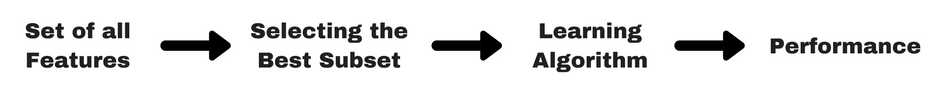

Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. The characteristics of these methods are as follows:-
* These methods rely on the characteristics of the data (feature characteristics)
* They do not use machine learning algorithms.
* These are model agnostic.
* They tend to be less computationally expensive.
* They usually give lower prediction performance than wrapper methods.
* They are very well suited for a quick screen and removal of irrelevant features.
  


Filter methods consists of various techniques as given below:
1. **Basic methods**: removing constant and quasi-constant features
2. **Univariate feature selection**: selecting the best features based on univariate statistical tests like ANOVA (most commonly used are SelectKBest or SelectPercentile)
3. **Correlation Matrix with Heatmap**: selecting features highly correlated with the target, yet uncorrelated to each other (As good variables are highly correlated with the target and uncorrelated among themselves)

In the following, we will start with the basic method.

# 1.1 Basic Methods
## Baseline Dataset

### Dropping constant features

In [56]:
df_base = df_full.copy()

In [57]:
const_feat = pd.DataFrame(df_base.nunique().sort_values(ascending=True), columns=["nunique"])[df_base.nunique()==1]
drop_feat = const_feat.index

In [58]:
drop_feat

Index(['ind_var2_0'], dtype='object')

In [59]:
df_base['ind_var2_0']

0        0
1        0
2        0
3        0
4        0
        ..
75813    0
75814    0
75815    0
75816    0
75817    0
Name: ind_var2_0, Length: 151838, dtype: int64

In [60]:
df_base.drop(drop_feat,axis=1, inplace=True)

In [61]:
df_base.set_index('ID', inplace=True)

In [62]:
df_base.shape

(151838, 309)

## Baseline model

Let's start with creating a training and test dataset

In [63]:
df_test_base = df_base[df_base["TARGET"].isna()==True]
df_train_base = df_base[df_base["TARGET"].isna()==False]

In [64]:
X_train, X_test, y_train, y_test = get_data_splits(dataframe=df_train_base, target_var='TARGET')

In [65]:
for each in [y_train, y_test]:
    print(f"Unhappy fraction = {each.mean():.4f}")

Unhappy fraction = 0.0395
Unhappy fraction = 0.0399


Although still highly unbalanced between happy and unhappy, both sets (i.e. train and test dataset) have an equal distribution of happy / unhappy people.

In [56]:
from  xgboost import XGBClassifier

In [67]:
model = XGBClassifier(n_estimators =100,
                      n_jobs=-1,
                      max_depth=3,
                      eta=1)

In [68]:
predictions, fit = get_model_predictions(model=model, 
                                         X_train = X_train,
                                         y_train = y_train,
                                         X_test = X_test,
                                         y_test=y_test,
                                         early_stopping=50)

[0]	validation_0-auc:0.80251	validation_1-auc:0.79318
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.81083	validation_1-auc:0.80398
[2]	validation_0-auc:0.82146	validation_1-auc:0.81696
[3]	validation_0-auc:0.82955	validation_1-auc:0.82193
[4]	validation_0-auc:0.83488	validation_1-auc:0.82929
[5]	validation_0-auc:0.83834	validation_1-auc:0.83068
[6]	validation_0-auc:0.84024	validation_1-auc:0.83323
[7]	validation_0-auc:0.84252	validation_1-auc:0.83172
[8]	validation_0-auc:0.84495	validation_1-auc:0.83183
[9]	validation_0-auc:0.84729	validation_1-auc:0.83158
[10]	validation_0-auc:0.84865	validation_1-auc:0.83346
[11]	validation_0-auc:0.84993	validation_1-auc:0.83454
[12]	validation_0-auc:0.85127	validation_1-auc:0.83304
[13]	validation_0-auc:0.85228	validation_1-auc:0.83282
[14]	validation_0-auc:0.85361	validation_1-auc:0.83288
[15]	validation_0-auc:0.8545

In [69]:
submissions = pd.DataFrame({
        "ID": X_test.reset_index()['ID'],
        "TARGET": predictions[:,1]
    })

In [70]:
comparison = pd.DataFrame({'# of Columns': X_test.shape[1], 
                           'AUC': roc_auc_score(y_test, predictions[:,1])},
                          index=['Constant'])
comparison

,# of Columns,AUC
Constant,308,0.834535


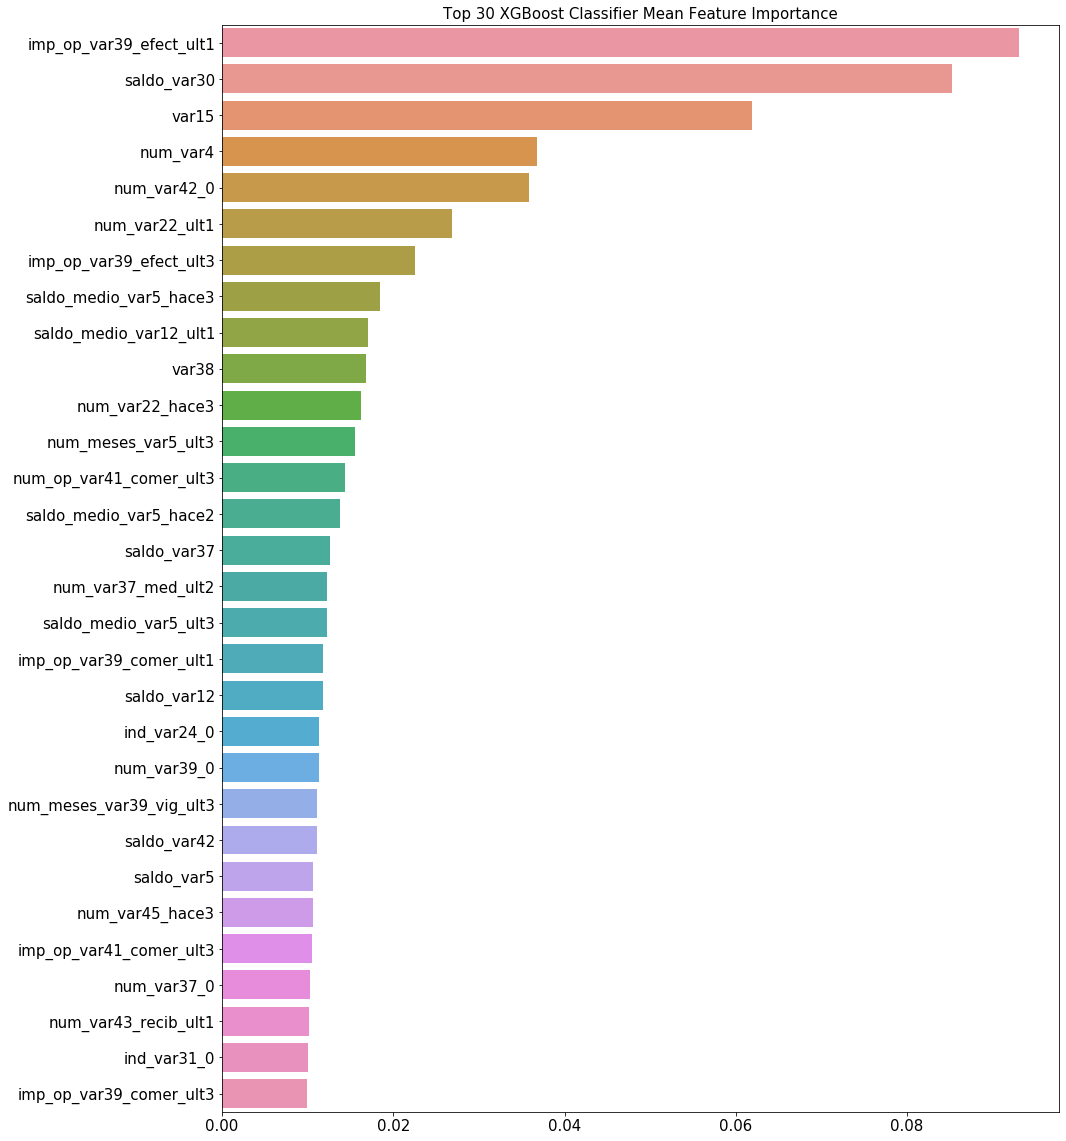

In [71]:
parameters = pd.Series(fit.feature_importances_, index=df_train_base.loc[:, df_train_base.columns != 'TARGET'].columns).sort_values(ascending=False)
plt.figure(figsize=(15, 20))
sns.barplot(x=parameters.iloc[:30], y=parameters.iloc[:30].index)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Top 30 XGBoost Classifier Mean Feature Importance', size=15)

plt.show()

Next we want to get our submissions and save them to a csv called XGBbase.

In [72]:
submissions = get_submission(fit=fit, 
                      X_train = df_train_base, 
                      y_train = df_train_base, 
                      X_test= df_test_base, 
                      target='TARGET',
                      submission_name='XGBbase')

Our model results in an public score of 0.82610. Quite good for our first try.

## Reduced Dataset
### Selecting and dropping quasi constant features

The same way we selected the features with 0 variance, we can also select features with close to zero variance (quasi-constant features).


In [73]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(df_train_full)  # fit finds the features with zero variance
train_data_new = sel.fit_transform(df_train_full)
selected_features = pd.DataFrame(sel.inverse_transform(train_data_new), index=df_train_full.index, columns=df_train_full.columns)
selected_columns = selected_features.columns[selected_features.var() != 0]
df_train_var001 = df_train_full[selected_columns]
# drop target variable to be able to subset for test_data
selected_columns = selected_columns.drop("TARGET")
df_test_var001 = df_test_full[selected_columns]


# resetting the index
df_test_var001.set_index('ID', inplace=True)
df_train_var001.set_index('ID', inplace=True)

print('Number of columns train dataset: '+str(df_train_var001.shape[1]))
print('Number of columns test dataset: '+str(df_test_var001.shape[1]))

Number of columns train dataset: 258
Number of columns test dataset: 257


In [74]:
len(df_train_full.columns)-df_train_var001.shape[1]

53

This means that 99 variables show predominantly one value for ~99% the observations of the training set.

In [75]:
X_train, X_test, y_train, y_test = get_data_splits(dataframe=df_train_var001, target_var='TARGET')

In [76]:
predictions, fit = get_model_predictions(model, 
                          early_stopping=50, 
                          X_train = X_train, 
                          y_train = y_train, 
                          X_test = X_test, 
                          y_test = y_test)

[0]	validation_0-auc:0.80251	validation_1-auc:0.79318
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.81083	validation_1-auc:0.80398
[2]	validation_0-auc:0.82146	validation_1-auc:0.81696
[3]	validation_0-auc:0.82955	validation_1-auc:0.82193
[4]	validation_0-auc:0.83488	validation_1-auc:0.82929
[5]	validation_0-auc:0.83834	validation_1-auc:0.83068
[6]	validation_0-auc:0.84024	validation_1-auc:0.83323
[7]	validation_0-auc:0.84252	validation_1-auc:0.83172
[8]	validation_0-auc:0.84495	validation_1-auc:0.83183
[9]	validation_0-auc:0.84729	validation_1-auc:0.83158
[10]	validation_0-auc:0.84865	validation_1-auc:0.83346
[11]	validation_0-auc:0.84993	validation_1-auc:0.83454
[12]	validation_0-auc:0.85127	validation_1-auc:0.83304
[13]	validation_0-auc:0.85228	validation_1-auc:0.83282
[14]	validation_0-auc:0.85361	validation_1-auc:0.83288
[15]	validation_0-auc:0.8545

In [77]:
results = pd.Series({'# of Columns': X_test.shape[1], 
                     'AUC': roc_auc_score(y_test, predictions[:,1])},
                      name='Quasi Constant')
comparison = comparison.append(results)
comparison

,# of Columns,AUC
Constant,308.0,0.834535
Quasi Constant,257.0,0.834535


Our predictions have not improved and still deliver the same auc 0.8345354640021606. Probably because the additional features we dropped now (with quasi zero variance) have not been of any important for the modeling before.

# 1.2 Univariate Method

In general,there are 4 methods that fall under this category :

* SelectKBest
* SelectPercentile
* SelectFpr, SelectFdr, or family wise error SelectFwe
* GenericUnivariateSelection


These objects take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile:
* For regression tasks: f_regression, mutual_info_regression
* For classification tasks: chi2, f_classif, mutual_info_classif

## SelectKBest
This method select features according to the k highest (e.g. the 10 highest) scores.

In [47]:
from sklearn.feature_selection import SelectKBest, f_classif

In [79]:
df_train_selectk = df_train_full.copy()
df_test_selectk = df_test_full.copy()

Let's select the 50 best features, using the f_classif (ANOVA f-value) method

In [80]:
# Create and fit selector
sel = SelectKBest(f_classif, k=50)
sel.fit(df_train_selectk.loc[:,df_train_selectk.columns !='TARGET'], df_train_selectk['TARGET'])
# Get columns to keep and create new dataframe with those only
selected_columns = sel.get_support(indices=True)
df_train_selectk = pd.concat([df_train_selectk.iloc[:,selected_columns],df_train_selectk['TARGET']], axis=1)
df_test_selectk = df_test_selectk.iloc[:,selected_columns]

print('Number of columns train dataset: '+str(df_train_selectk.shape[1]))
print('Number of columns test dataset: '+str(df_test_selectk.shape[1]))

Number of columns train dataset: 51
Number of columns test dataset: 50


In [81]:
X_train, X_test, y_train, y_test = get_data_splits(dataframe=df_train_selectk, target_var='TARGET')

In [82]:
predictions, fit = get_model_predictions(model, 
                          early_stopping=50, 
                          X_train = X_train, 
                          y_train = y_train, 
                          X_test = X_test, 
                          y_test = y_test)

[0]	validation_0-auc:0.79907	validation_1-auc:0.79104
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.80663	validation_1-auc:0.80163
[2]	validation_0-auc:0.81916	validation_1-auc:0.81242
[3]	validation_0-auc:0.82468	validation_1-auc:0.81924
[4]	validation_0-auc:0.82831	validation_1-auc:0.82123
[5]	validation_0-auc:0.82976	validation_1-auc:0.82537
[6]	validation_0-auc:0.83189	validation_1-auc:0.82637
[7]	validation_0-auc:0.83403	validation_1-auc:0.82749
[8]	validation_0-auc:0.83450	validation_1-auc:0.82782
[9]	validation_0-auc:0.83534	validation_1-auc:0.82703
[10]	validation_0-auc:0.83553	validation_1-auc:0.82570
[11]	validation_0-auc:0.83683	validation_1-auc:0.82657
[12]	validation_0-auc:0.83738	validation_1-auc:0.82664
[13]	validation_0-auc:0.83850	validation_1-auc:0.82670
[14]	validation_0-auc:0.83936	validation_1-auc:0.82610
[15]	validation_0-auc:0.8401

In [83]:
results = pd.Series({'# of Columns': X_test.shape[1], 'AUC': roc_auc_score(y_test, predictions[:,1])},name='Select 50 best')
comparison = comparison.append(results)
comparison

,# of Columns,AUC
Constant,308.0,0.834535
Quasi Constant,257.0,0.834535
Select 50 best,50.0,0.827818


Our models auc value slightly decreases to 0.82782.

## Select Percentile

This method selects features according to a percentile of the highest scores.

In [44]:
from sklearn.feature_selection import SelectPercentile

In [45]:
df_train_selectperc = df_train_full.copy()
df_test_selectperc = df_test_full.copy()

We will here select the top 20 percentile.

In [48]:
# Create and fit selector
sel = SelectPercentile(f_classif, percentile=20)
sel.fit(df_train_selectperc.loc[:,df_train_selectperc.columns !='TARGET'], df_train_selectperc['TARGET'])
# Get columns to keep and create new dataframe with those only
selected_columns = sel.get_support(indices=True)
df_train_selectperc = pd.concat([df_train_selectperc.iloc[:,selected_columns],df_train_selectperc['TARGET']], axis=1)
df_test_selectperc = df_test_selectperc.iloc[:,selected_columns]

print('Number of columns train dataset: '+str(df_train_selectperc.shape[1]))
print('Number of columns test dataset: '+str(df_test_selectperc.shape[1]))

Number of columns train dataset: 63
Number of columns test dataset: 62


In [49]:
X_train, X_test, y_train, y_test = get_data_splits(dataframe=df_train_selectperc, target_var='TARGET')

In [88]:
predictions, fit = get_model_predictions(model, 
                          early_stopping=50, 
                          X_train = X_train, 
                          y_train = y_train, 
                          X_test = X_test, 
                          y_test = y_test)

[0]	validation_0-auc:0.79907	validation_1-auc:0.79104
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.80663	validation_1-auc:0.80163
[2]	validation_0-auc:0.81524	validation_1-auc:0.81339
[3]	validation_0-auc:0.82381	validation_1-auc:0.81868
[4]	validation_0-auc:0.82806	validation_1-auc:0.82350
[5]	validation_0-auc:0.82994	validation_1-auc:0.82503
[6]	validation_0-auc:0.83122	validation_1-auc:0.82814
[7]	validation_0-auc:0.83255	validation_1-auc:0.82766
[8]	validation_0-auc:0.83493	validation_1-auc:0.82717
[9]	validation_0-auc:0.83632	validation_1-auc:0.82633
[10]	validation_0-auc:0.83708	validation_1-auc:0.82725
[11]	validation_0-auc:0.83831	validation_1-auc:0.82487
[12]	validation_0-auc:0.83874	validation_1-auc:0.82437
[13]	validation_0-auc:0.83948	validation_1-auc:0.82292
[14]	validation_0-auc:0.84040	validation_1-auc:0.82283
[15]	validation_0-auc:0.8413

In [89]:
results = pd.Series({'# of Columns': X_test.shape[1], 'AUC': roc_auc_score(y_test, predictions[:,1])},name='Select 20 percentile')
comparison = comparison.append(results)
comparison

,# of Columns,AUC
Constant,308.0,0.834535
Quasi Constant,257.0,0.834535
Select 50 best,50.0,0.827818
Select 20 percentile,62.0,0.828140


In comparison to selctkbest, now we have improved a little, reaching an auc of 0.83.

# 1.3 Correlation-Matrix
Goal of this feature selection is to find variables that are correlated with the target but uncorrelated among themselves. At first we need to find features that are correlated with each other. By identifying these features, we can then decide which features we want to keep, and which ones we want to remove.

In this analysis we will use Pearson correlation to check if the selected variables are highly correlated with each other. If they are, we would then need to keep just one of the correlated ones and drop the others.

In [90]:
corr_matrix = df_train_full.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [91]:
upper.head()

,ID,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var33_0,ind_var33,ind_var34_0,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var44_0,ind_var44,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var33,num_var34_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var13_medio_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var4

In [92]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
len(to_drop)

137

In [93]:
df_train_corr = df_train_full.copy()
df_test_corr = df_test_full.copy()

In [94]:
df_train_corr = df_train_corr.drop(to_drop, axis=1)
df_test_corr = df_test_corr.drop(to_drop, axis=1)

print('Number of columns train dataset: '+str(df_train_corr.shape[1]))
print('Number of columns test dataset: '+str(df_test_corr.shape[1]))

Number of columns train dataset: 174
Number of columns test dataset: 174


In [95]:
X_train, X_test, y_train, y_test = get_data_splits(dataframe=df_train_corr, target_var='TARGET')

In [96]:
predictions, fit = get_model_predictions(model, 
                          early_stopping=50, 
                          X_train = X_train, 
                          y_train = y_train, 
                          X_test = X_test, 
                          y_test = y_test)

[0]	validation_0-auc:0.80427	validation_1-auc:0.79293
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.81471	validation_1-auc:0.80809
[2]	validation_0-auc:0.82567	validation_1-auc:0.82006
[3]	validation_0-auc:0.83197	validation_1-auc:0.82237
[4]	validation_0-auc:0.83609	validation_1-auc:0.82548
[5]	validation_0-auc:0.83938	validation_1-auc:0.83028
[6]	validation_0-auc:0.84088	validation_1-auc:0.82978
[7]	validation_0-auc:0.84279	validation_1-auc:0.83045
[8]	validation_0-auc:0.84574	validation_1-auc:0.83047
[9]	validation_0-auc:0.84731	validation_1-auc:0.82961
[10]	validation_0-auc:0.84874	validation_1-auc:0.83000
[11]	validation_0-auc:0.85064	validation_1-auc:0.83093
[12]	validation_0-auc:0.85143	validation_1-auc:0.83039
[13]	validation_0-auc:0.85309	validation_1-auc:0.82832
[14]	validation_0-auc:0.85524	validation_1-auc:0.82852
[15]	validation_0-auc:0.8562

In [97]:
results = pd.Series({'# of Columns': X_test.shape[1], 'AUC': roc_auc_score(y_test, predictions[:,1])},name='High correlation')
comparison = comparison.append(results)
comparison

,# of Columns,AUC
Constant,308.0,0.834535
Quasi Constant,257.0,0.834535
Select 50 best,50.0,0.827818
Select 20 percentile,62.0,0.828140
High correlation,173.0,0.830931


This model has pretty much the same auc as the ones before.

In [98]:
gc.collect()

7811

# 2. Wrapper Methods

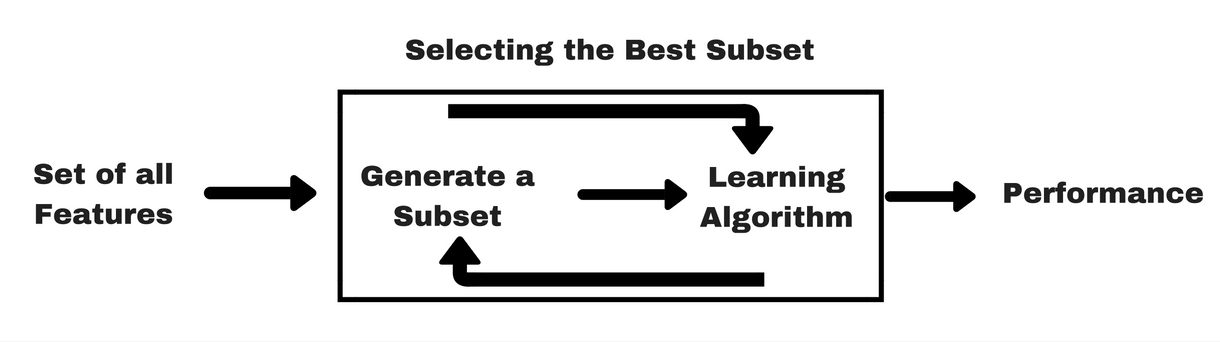

In wrapper methods, we try to use a subset of features and train a model using them. Based on the inferences that we draw from the previous model, we decide to add or remove features from the subset. The problem is essentially reduced to a search problem. These methods are usually computationally very expensive.
Some common examples of wrapper methods are
1. Forward selection,
2. Backward elimination,
3. Exhaustive feature selection,
4. Recursive feature elimination.
5. Recursive feature elimination with cross-validation


## 2.1 Forward selection
Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

In [99]:
# !pip install mlxtend

In [100]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

At first we have to create our Sequential Feature Selector, choosing forward as the selection method.

In [101]:
from sklearn.metrics import SCORERS as XYZ

In [102]:
XYZ.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [103]:
model

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [104]:
sfs1 = SFS(model,
           k_features = (10),
           forward = True,
           verbose = 2,
           scoring = 'roc_auc',
           cv = 5,
           n_jobs = -1)

In [105]:
df_train_forward = df_train_full.copy()
df_test_forward = df_test_full.copy()

In [106]:
drop = pd.DataFrame((df_test_forward < 0).any())[(df_test_forward < 0).any()==True].index

In [107]:
df_test_forward = df_test_forward.drop(drop, axis=1)

In [108]:
X_train, X_test, y_train, y_test = get_data_splits(dataframe=df_train_forward, target_var='TARGET')

In [109]:
sfs1 = sfs1.fit(np.array(X_train), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed: 28.8min finished

[2020-05-05 21:53:55] Features: 1/10 -- score: 0.7118268019219187[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 309 out of 309 | elapsed: 35.2min finished

[2020-05-05 22:29:05] Features: 2/10 -- score: 0.8027035290258029[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 308 out of 308 | elapsed: 40.2min finished

[2020-05-05 23:09:15] Features: 3/10 -- score: 0.80736

This took quite a while (>9 hours). 
We can take a look ath the selected feature indices at each step (with 5 fold cross validation and the selected features).

In [110]:
sfs1.subsets_

{1: {'feature_idx': (144,),
  'cv_scores': array([0.68368018, 0.72471932, 0.71811179, 0.73584089, 0.69678183]),
  'avg_score': 0.7118268019219187,
  'feature_names': ('144',)},
 2: {'feature_idx': (1, 144),
  'cv_scores': array([0.77665916, 0.81310924, 0.79960234, 0.83017739, 0.79396951]),
  'avg_score': 0.8027035290258029,
  'feature_names': ('1', '144')},
 3: {'feature_idx': (1, 71, 144),
  'cv_scores': array([0.78610008, 0.81419129, 0.80780425, 0.82757595, 0.80116007]),
  'avg_score': 0.8073663297356377,
  'feature_names': ('1', '71', '144')},
 4: {'feature_idx': (1, 71, 144, 299),
  'cv_scores': array([0.78875636, 0.81233149, 0.80780425, 0.82880325, 0.8026964 ]),
  'avg_score': 0.8080783495770014,
  'feature_names': ('1', '71', '144', '299')},
 5: {'feature_idx': (1, 71, 144, 157, 299),
  'cv_scores': array([0.78711725, 0.81429285, 0.80780425, 0.82880325, 0.8026964 ]),
  'avg_score': 0.8081428004061317,
  'feature_names': ('1', '71', '144', '157', '299')},
 6: {'feature_idx': (1, 7

These are the names of the variables:

In [111]:
seleted_features = sfs1.k_feature_idx_
selected_columns = X_train.columns[list(sfs1.k_feature_idx_)]
selected_columns

Index(['var15', 'ind_var13_corto', 'ind_var33', 'num_var5_0', 'num_var30_0',
       'saldo_var30', 'delta_imp_aport_var17_1y3', 'num_var22_ult1',
       'saldo_medio_var13_corto_ult3', 'saldo_medio_var33_hace3'],
      dtype='object')

And the final AUC score:

In [112]:
sfs1.k_score_

0.8131024515633563

In [113]:
results = pd.Series({'# of Columns': X_test.shape[1], 'AUC': sfs1.k_score_},name='Forward Selection')
comparison = comparison.append(results)
comparison

,# of Columns,AUC
Constant,308.0,0.834535
Quasi Constant,257.0,0.834535
Select 50 best,50.0,0.827818
Select 20 percentile,62.0,0.828140
High correlation,173.0,0.830931
Forward Selection,310.0,0.813102


In [114]:
gc.collect()

4154

# 3. Embedded Methods
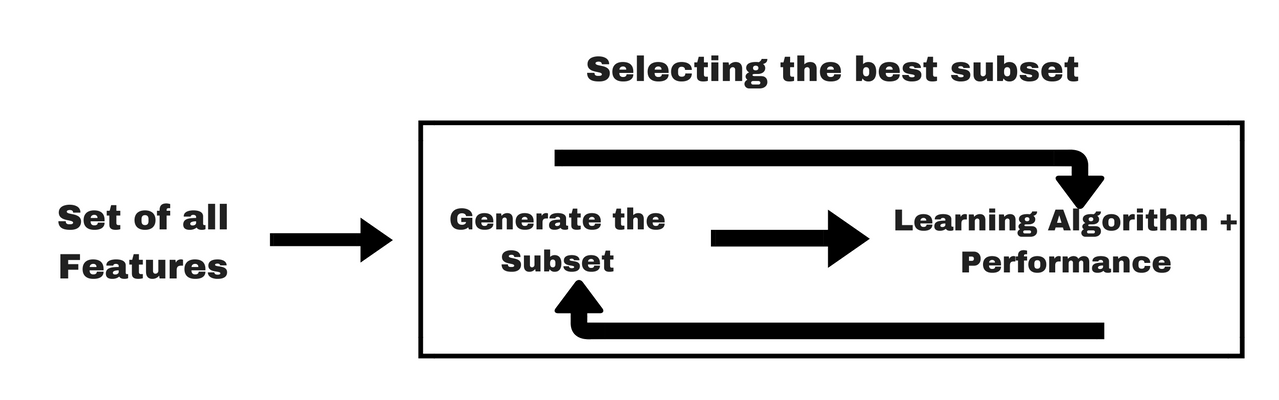

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.
This is why Regularization methods are also called penalization methods that introduce additional constraints into the optimization of a predictive algorithm (such as a regression algorithm) that bias the model toward lower complexity (fewer coefficients). 

## 3.1 L1 Regularization (Lasso)
Lasso regression performs L1 regularization which adds penalty equivalent to **absolute value** of the magnitude of coefficients. Lasso has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In [115]:
df_train_lasso = df_train_full.copy()
df_test_lasso = df_test_full.copy()

In [116]:
X_train, X_test, y_train, y_test = get_data_splits(dataframe=df_train_lasso, target_var='TARGET')

In [117]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel

In [ ]:
from sklearn.preprocessing import StandardScaler
# Set the regularization parameter C=100 (the smaller the more shrinkage will take place)
logistic = LogisticRegressionCV(Cs=100, penalty="l1", random_state=42, solver = 'liblinear', scoring ='roc_auc').fit(X_train, y_train)
sel_ = SelectFromModel(logistic, prefit=True)
predictions = logistic.predict_proba(X_test)
print('AUC value: {}'.format(roc_auc_score(y_test, predictions[:,1])))

In [ ]:
results = pd.Series({'# of Columns': X_test.shape[1], 'AUC': roc_auc_score(y_test, predictions[:,1])},name='Lasso Regression')
comparison = comparison.append(results)
comparison

In [ ]:
selected_feat = X_train.columns[(sel_.get_support())]
selected_feat

In [ ]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

We can see that Lasso regularisation helps to remove non-important features from the dataset. So, increasing the penalisation (i.e. lowering the Cs-value) will result in increase the number of features removed. Therefore, we need to keep an eye and monitor that we don't set a penalty too high so that to remove even important features, or too low and then not remove non-important features. If the penalty is too high and important features are removed, we will notice a drop in the performance of the algorithm and then realise that we need to decrease the regularisation.

In [ ]:
df_train_lasso = df_train_lasso[selected_feat]
df_test_lasso = df_test_lasso[selected_feat]

## 3.2 L2 Regularization (Ridge)

Similar to L1 regularization, L2 regularization works the same way, only that it takes the squared value of the coefficients instead of the absolute value.

In [ ]:
df_train_ridge = df_train_full.copy()
df_test_ridge = df_test_full.copy()

In [ ]:
X_train, X_test, y_train, y_test = get_data_splits(dataframe=df_train_ridge, target_var='TARGET')

In [ ]:
from sklearn.preprocessing import StandardScaler
# Set the regularization parameter C=100 (the smaller the more shrinkage will take place)
logistic = LogisticRegressionCV(Cs=100, penalty="l2", random_state=42, solver = 'liblinear', scoring ='roc_auc').fit(X_train, y_train)
sel_ = SelectFromModel(logistic, prefit=True)
predictions = logistic.predict_proba(X_test)
print('AUC value: {}'.format(roc_auc_score(y_test, predictions[:,1])))
print('selected features: {}'.format(len(X_train.columns[(sel_.get_support())])))

In [ ]:
results = pd.Series({'# of Columns': X_test.shape[1], 'AUC': roc_auc_score(y_test, predictions[:,1])},name='Ridge Regression')
comparison = comparison.append(results)
comparison

In [ ]:
gc.collect()

## Grid Search

Another method to further improve our model is using grid search, rerunning the model several times with slightly changed parameters.

For Grid Search, we take one of our best reduced models (i.e. with a high auc value but a reduced number of features). Since the model with the features selected through select 20 percentile worked quite well and reduced the complexity to 62 columns, 

In [52]:
X_train, X_test, y_train, y_test = get_data_splits(dataframe=df_train_selectperc, target_var='TARGET')

In [53]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

We take the following parameter options:

In [54]:
params = {
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.5, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
        'max_depth': [2, 5, 10, 15],
        'learning_rate': [0.05, 0.1, 0.2],
        'reg_alpha': [0.01, 0.03, 0.05, 0.1]
        }

In [57]:
xgb = XGBClassifier(n_estimators=1000, objective='binary:logistic',
                    silent=True, n_jobs=-1)

In [58]:
folds = 5
param_comb = 10

# cross validation with 5 folds 
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = SEED)

# randomized search over 10 combinations, each sampled from a distribution of possible parameter values (params)
random_search = RandomizedSearchCV(xgb,
                                   param_distributions = params,
                                   n_iter=param_comb,
                                   scoring='roc_auc',
                                   #n_jobs=-1,
                                   cv=skf.split(X_train,y_train),
                                   verbose=3,
                                   random_state=SEED)


# stop after 50 rounds of no model improvement (i.e. number of epochs on which we would like to see no improvement)
random_search.fit(X_train, y_train, early_stopping_rounds=25, eval_metric="auc",
               eval_set=[(X_train,y_train),(X_test,y_test)])

XGB_optimum = random_search.best_estimator_

# Best AUC Score
random_search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=0.8, reg_alpha=0.03, min_child_weight=5, max_depth=5, learning_rate=0.1, gamma=1, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0]	validation_0-auc:0.80900	validation_1-auc:0.79700
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.81672	validation_1-auc:0.80855
[2]	validation_0-auc:0.81913	validation_1-auc:0.81088
[3]	validation_0-auc:0.82470	validation_1-auc:0.81502
[4]	validation_0-auc:0.82440	validation_1-auc:0.80936
[5]	validation_0-auc:0.82583	validation_1-auc:0.81038
[6]	validation_0-auc:0.82732	validation_1-auc:0.81403
[7]	validation_0-auc:0.82497	validation_1-auc:0.80758
[8]	validation_0-auc:0.82566	validation_1-auc:0.80762
[9]	validation_0-auc:0.82370	validation_1-auc:0.80519
[10]	validation_0-auc:0.82612	validation_1-auc:0.80858
[11]	validation_0-auc:0.82769	validation_1-auc:0.81051
[12]	validation_0-auc:0.82810	validation_1-auc:0.81148
[13]	validation_0-auc:0.83019	validation_1-auc:0.81649
[14]	validation_0-auc:0.83006	validation_1-auc:0.81643
[15]	validation_0-auc:0.8290

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.1s remaining:    0.0s


[0]	validation_0-auc:0.81371	validation_1-auc:0.80532
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.81709	validation_1-auc:0.80642
[2]	validation_0-auc:0.81838	validation_1-auc:0.80839
[3]	validation_0-auc:0.81851	validation_1-auc:0.80837
[4]	validation_0-auc:0.82245	validation_1-auc:0.81387
[5]	validation_0-auc:0.82104	validation_1-auc:0.80595
[6]	validation_0-auc:0.82235	validation_1-auc:0.80708
[7]	validation_0-auc:0.82273	validation_1-auc:0.80876
[8]	validation_0-auc:0.82603	validation_1-auc:0.81585
[9]	validation_0-auc:0.82641	validation_1-auc:0.81795
[10]	validation_0-auc:0.82536	validation_1-auc:0.80907
[11]	validation_0-auc:0.82563	validation_1-auc:0.80705
[12]	validation_0-auc:0.82653	validation_1-auc:0.80792
[13]	validation_0-auc:0.82811	validation_1-auc:0.80934
[14]	validation_0-auc:0.82966	validation_1-auc:0.81090
[15]	validation_0-auc:0.8312

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.6s remaining:    0.0s


[0]	validation_0-auc:0.80979	validation_1-auc:0.80192
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.81566	validation_1-auc:0.80613
[2]	validation_0-auc:0.81777	validation_1-auc:0.80750
[3]	validation_0-auc:0.82092	validation_1-auc:0.81429
[4]	validation_0-auc:0.82266	validation_1-auc:0.81420
[5]	validation_0-auc:0.82086	validation_1-auc:0.80542
[6]	validation_0-auc:0.82140	validation_1-auc:0.80759
[7]	validation_0-auc:0.82469	validation_1-auc:0.81432
[8]	validation_0-auc:0.82554	validation_1-auc:0.81286
[9]	validation_0-auc:0.82556	validation_1-auc:0.81301
[10]	validation_0-auc:0.82419	validation_1-auc:0.80799
[11]	validation_0-auc:0.82213	validation_1-auc:0.80640
[12]	validation_0-auc:0.82231	validation_1-auc:0.80642
[13]	validation_0-auc:0.82407	validation_1-auc:0.80880
[14]	validation_0-auc:0.82605	validation_1-auc:0.81373
[15]	validation_0-auc:0.8262

[37]	validation_0-auc:0.83805	validation_1-auc:0.82601
[38]	validation_0-auc:0.83811	validation_1-auc:0.82606
[39]	validation_0-auc:0.83801	validation_1-auc:0.82674
[40]	validation_0-auc:0.83810	validation_1-auc:0.82705
[41]	validation_0-auc:0.83834	validation_1-auc:0.82685
[42]	validation_0-auc:0.83852	validation_1-auc:0.82745
[43]	validation_0-auc:0.83854	validation_1-auc:0.82737
[44]	validation_0-auc:0.83844	validation_1-auc:0.82757
[45]	validation_0-auc:0.83900	validation_1-auc:0.82786
[46]	validation_0-auc:0.83913	validation_1-auc:0.82788
[47]	validation_0-auc:0.83963	validation_1-auc:0.82741
[48]	validation_0-auc:0.83981	validation_1-auc:0.82756
[49]	validation_0-auc:0.83978	validation_1-auc:0.82714
[50]	validation_0-auc:0.83972	validation_1-auc:0.82709
[51]	validation_0-auc:0.83977	validation_1-auc:0.82713
[52]	validation_0-auc:0.83999	validation_1-auc:0.82711
[53]	validation_0-auc:0.84010	validation_1-auc:0.82710
[54]	validation_0-auc:0.84014	validation_1-auc:0.82732
[55]	valid

[56]	validation_0-auc:0.84189	validation_1-auc:0.82720
[57]	validation_0-auc:0.84197	validation_1-auc:0.82703
[58]	validation_0-auc:0.84216	validation_1-auc:0.82706
[59]	validation_0-auc:0.84230	validation_1-auc:0.82673
[60]	validation_0-auc:0.84244	validation_1-auc:0.82689
[61]	validation_0-auc:0.84255	validation_1-auc:0.82672
[62]	validation_0-auc:0.84289	validation_1-auc:0.82711
[63]	validation_0-auc:0.84298	validation_1-auc:0.82720
[64]	validation_0-auc:0.84296	validation_1-auc:0.82745
[65]	validation_0-auc:0.84322	validation_1-auc:0.82742
[66]	validation_0-auc:0.84339	validation_1-auc:0.82782
[67]	validation_0-auc:0.84339	validation_1-auc:0.82785
[68]	validation_0-auc:0.84366	validation_1-auc:0.82790
[69]	validation_0-auc:0.84393	validation_1-auc:0.82793
[70]	validation_0-auc:0.84413	validation_1-auc:0.82829
[71]	validation_0-auc:0.84429	validation_1-auc:0.82830
[72]	validation_0-auc:0.84445	validation_1-auc:0.82818
[73]	validation_0-auc:0.84454	validation_1-auc:0.82786
[74]	valid

[99]	validation_0-auc:0.83672	validation_1-auc:0.81737
[100]	validation_0-auc:0.83677	validation_1-auc:0.81743
[101]	validation_0-auc:0.83709	validation_1-auc:0.81816
[102]	validation_0-auc:0.83718	validation_1-auc:0.81839
[103]	validation_0-auc:0.83754	validation_1-auc:0.81898
[104]	validation_0-auc:0.83767	validation_1-auc:0.81945
[105]	validation_0-auc:0.83776	validation_1-auc:0.81924
[106]	validation_0-auc:0.83827	validation_1-auc:0.82002
[107]	validation_0-auc:0.83835	validation_1-auc:0.82028
[108]	validation_0-auc:0.83858	validation_1-auc:0.82080
[109]	validation_0-auc:0.83857	validation_1-auc:0.82057
[110]	validation_0-auc:0.83883	validation_1-auc:0.82058
[111]	validation_0-auc:0.83890	validation_1-auc:0.82069
[112]	validation_0-auc:0.83873	validation_1-auc:0.82014
[113]	validation_0-auc:0.83884	validation_1-auc:0.82014
[114]	validation_0-auc:0.83943	validation_1-auc:0.82087
[115]	validation_0-auc:0.83947	validation_1-auc:0.82105
[116]	validation_0-auc:0.84015	validation_1-auc:0

[0]	validation_0-auc:0.77755	validation_1-auc:0.76164
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.81034	validation_1-auc:0.79734
[2]	validation_0-auc:0.80972	validation_1-auc:0.79697
[3]	validation_0-auc:0.81295	validation_1-auc:0.79978
[4]	validation_0-auc:0.81300	validation_1-auc:0.79769
[5]	validation_0-auc:0.81195	validation_1-auc:0.79073
[6]	validation_0-auc:0.81704	validation_1-auc:0.80115
[7]	validation_0-auc:0.80693	validation_1-auc:0.78385
[8]	validation_0-auc:0.80656	validation_1-auc:0.78391
[9]	validation_0-auc:0.81371	validation_1-auc:0.79201
[10]	validation_0-auc:0.80979	validation_1-auc:0.79161
[11]	validation_0-auc:0.80878	validation_1-auc:0.79024
[12]	validation_0-auc:0.80946	validation_1-auc:0.79073
[13]	validation_0-auc:0.80881	validation_1-auc:0.78977
[14]	validation_0-auc:0.81159	validation_1-auc:0.79269
[15]	validation_0-auc:0.8108

[1]	validation_0-auc:0.81297	validation_1-auc:0.80045
[2]	validation_0-auc:0.81239	validation_1-auc:0.80000
[3]	validation_0-auc:0.82232	validation_1-auc:0.80837
[4]	validation_0-auc:0.82217	validation_1-auc:0.80857
[5]	validation_0-auc:0.81847	validation_1-auc:0.79822
[6]	validation_0-auc:0.82079	validation_1-auc:0.80406
[7]	validation_0-auc:0.80888	validation_1-auc:0.78604
[8]	validation_0-auc:0.80850	validation_1-auc:0.78602
[9]	validation_0-auc:0.81050	validation_1-auc:0.78782
[10]	validation_0-auc:0.80978	validation_1-auc:0.78713
[11]	validation_0-auc:0.80971	validation_1-auc:0.78784
[12]	validation_0-auc:0.81034	validation_1-auc:0.78851
[13]	validation_0-auc:0.81005	validation_1-auc:0.78733
[14]	validation_0-auc:0.81168	validation_1-auc:0.78915
[15]	validation_0-auc:0.81176	validation_1-auc:0.79052
[16]	validation_0-auc:0.81191	validation_1-auc:0.79113
[17]	validation_0-auc:0.81220	validation_1-auc:0.79275
[18]	validation_0-auc:0.81640	validation_1-auc:0.79722
[19]	validation_0-a

[111]	validation_0-auc:0.82711	validation_1-auc:0.82094
[112]	validation_0-auc:0.82739	validation_1-auc:0.82074
[113]	validation_0-auc:0.82734	validation_1-auc:0.82126
[114]	validation_0-auc:0.82790	validation_1-auc:0.82080
[115]	validation_0-auc:0.82801	validation_1-auc:0.82085
[116]	validation_0-auc:0.82791	validation_1-auc:0.82110
[117]	validation_0-auc:0.82808	validation_1-auc:0.82103
[118]	validation_0-auc:0.82809	validation_1-auc:0.82108
[119]	validation_0-auc:0.82825	validation_1-auc:0.82108
[120]	validation_0-auc:0.82830	validation_1-auc:0.82097
[121]	validation_0-auc:0.82851	validation_1-auc:0.82146
[122]	validation_0-auc:0.82855	validation_1-auc:0.82165
[123]	validation_0-auc:0.82861	validation_1-auc:0.82172
[124]	validation_0-auc:0.82856	validation_1-auc:0.82178
[125]	validation_0-auc:0.82868	validation_1-auc:0.82180
[126]	validation_0-auc:0.82899	validation_1-auc:0.82213
[127]	validation_0-auc:0.82900	validation_1-auc:0.82223
[128]	validation_0-auc:0.82914	validation_1-auc:

[258]	validation_0-auc:0.83460	validation_1-auc:0.82786
[259]	validation_0-auc:0.83465	validation_1-auc:0.82794
[260]	validation_0-auc:0.83460	validation_1-auc:0.82781
[261]	validation_0-auc:0.83460	validation_1-auc:0.82781
[262]	validation_0-auc:0.83458	validation_1-auc:0.82820
[263]	validation_0-auc:0.83458	validation_1-auc:0.82820
[264]	validation_0-auc:0.83458	validation_1-auc:0.82820
[265]	validation_0-auc:0.83458	validation_1-auc:0.82820
[266]	validation_0-auc:0.83460	validation_1-auc:0.82819
[267]	validation_0-auc:0.83460	validation_1-auc:0.82819
[268]	validation_0-auc:0.83460	validation_1-auc:0.82819
[269]	validation_0-auc:0.83460	validation_1-auc:0.82819
[270]	validation_0-auc:0.83465	validation_1-auc:0.82820
[271]	validation_0-auc:0.83465	validation_1-auc:0.82820
[272]	validation_0-auc:0.83465	validation_1-auc:0.82820
[273]	validation_0-auc:0.83468	validation_1-auc:0.82826
[274]	validation_0-auc:0.83469	validation_1-auc:0.82809
[275]	validation_0-auc:0.83469	validation_1-auc:

[CV] subsample=0.8, reg_alpha=0.1, min_child_weight=1, max_depth=2, learning_rate=0.05, gamma=5, colsample_bytree=0.6 
[0]	validation_0-auc:0.71684	validation_1-auc:0.69098
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.73049	validation_1-auc:0.70330
[2]	validation_0-auc:0.77290	validation_1-auc:0.75205
[3]	validation_0-auc:0.78126	validation_1-auc:0.77235
[4]	validation_0-auc:0.78124	validation_1-auc:0.77234
[5]	validation_0-auc:0.77981	validation_1-auc:0.75747
[6]	validation_0-auc:0.78268	validation_1-auc:0.75970
[7]	validation_0-auc:0.78231	validation_1-auc:0.75875
[8]	validation_0-auc:0.78189	validation_1-auc:0.75857
[9]	validation_0-auc:0.78206	validation_1-auc:0.75877
[10]	validation_0-auc:0.77960	validation_1-auc:0.75745
[11]	validation_0-auc:0.77969	validation_1-auc:0.75704
[12]	validation_0-auc:0.77980	validation_1-auc:0.75734
[13]	validation_0-a

[144]	validation_0-auc:0.83078	validation_1-auc:0.82582
[145]	validation_0-auc:0.83085	validation_1-auc:0.82586
[146]	validation_0-auc:0.83083	validation_1-auc:0.82575
[147]	validation_0-auc:0.83086	validation_1-auc:0.82573
[148]	validation_0-auc:0.83084	validation_1-auc:0.82581
[149]	validation_0-auc:0.83084	validation_1-auc:0.82576
[150]	validation_0-auc:0.83092	validation_1-auc:0.82572
[151]	validation_0-auc:0.83095	validation_1-auc:0.82588
[152]	validation_0-auc:0.83114	validation_1-auc:0.82609
[153]	validation_0-auc:0.83116	validation_1-auc:0.82626
[154]	validation_0-auc:0.83121	validation_1-auc:0.82634
[155]	validation_0-auc:0.83122	validation_1-auc:0.82638
[156]	validation_0-auc:0.83130	validation_1-auc:0.82640
[157]	validation_0-auc:0.83132	validation_1-auc:0.82627
[158]	validation_0-auc:0.83146	validation_1-auc:0.82633
[159]	validation_0-auc:0.83151	validation_1-auc:0.82631
[160]	validation_0-auc:0.83159	validation_1-auc:0.82638
[161]	validation_0-auc:0.83158	validation_1-auc:

[291]	validation_0-auc:0.83434	validation_1-auc:0.82858
[292]	validation_0-auc:0.83433	validation_1-auc:0.82856
[293]	validation_0-auc:0.83433	validation_1-auc:0.82856
[294]	validation_0-auc:0.83433	validation_1-auc:0.82856
[295]	validation_0-auc:0.83440	validation_1-auc:0.82863
[296]	validation_0-auc:0.83446	validation_1-auc:0.82852
[297]	validation_0-auc:0.83453	validation_1-auc:0.82869
[298]	validation_0-auc:0.83453	validation_1-auc:0.82869
[299]	validation_0-auc:0.83453	validation_1-auc:0.82869
[300]	validation_0-auc:0.83453	validation_1-auc:0.82869
[301]	validation_0-auc:0.83458	validation_1-auc:0.82867
[302]	validation_0-auc:0.83458	validation_1-auc:0.82867
[303]	validation_0-auc:0.83455	validation_1-auc:0.82880
[304]	validation_0-auc:0.83457	validation_1-auc:0.82868
[305]	validation_0-auc:0.83462	validation_1-auc:0.82869
[306]	validation_0-auc:0.83465	validation_1-auc:0.82882
[307]	validation_0-auc:0.83465	validation_1-auc:0.82882
[308]	validation_0-auc:0.83465	validation_1-auc:

[25]	validation_0-auc:0.78557	validation_1-auc:0.76297
[26]	validation_0-auc:0.78468	validation_1-auc:0.76219
[27]	validation_0-auc:0.78316	validation_1-auc:0.76061
[28]	validation_0-auc:0.78317	validation_1-auc:0.76079
[29]	validation_0-auc:0.78363	validation_1-auc:0.76097
[30]	validation_0-auc:0.78355	validation_1-auc:0.76174
[31]	validation_0-auc:0.78366	validation_1-auc:0.76189
[32]	validation_0-auc:0.79568	validation_1-auc:0.77953
[33]	validation_0-auc:0.79691	validation_1-auc:0.78137
[34]	validation_0-auc:0.79651	validation_1-auc:0.78095
[35]	validation_0-auc:0.79668	validation_1-auc:0.78134
[36]	validation_0-auc:0.79672	validation_1-auc:0.78047
[37]	validation_0-auc:0.79776	validation_1-auc:0.78210
[38]	validation_0-auc:0.80719	validation_1-auc:0.79785
[39]	validation_0-auc:0.80728	validation_1-auc:0.79795
[40]	validation_0-auc:0.80790	validation_1-auc:0.79891
[41]	validation_0-auc:0.80786	validation_1-auc:0.79842
[42]	validation_0-auc:0.80926	validation_1-auc:0.80046
[43]	valid

[173]	validation_0-auc:0.83222	validation_1-auc:0.82684
[174]	validation_0-auc:0.83224	validation_1-auc:0.82689
[175]	validation_0-auc:0.83228	validation_1-auc:0.82692
[176]	validation_0-auc:0.83233	validation_1-auc:0.82706
[177]	validation_0-auc:0.83234	validation_1-auc:0.82705
[178]	validation_0-auc:0.83240	validation_1-auc:0.82711
[179]	validation_0-auc:0.83251	validation_1-auc:0.82720
[180]	validation_0-auc:0.83256	validation_1-auc:0.82728
[181]	validation_0-auc:0.83257	validation_1-auc:0.82714
[182]	validation_0-auc:0.83261	validation_1-auc:0.82720
[183]	validation_0-auc:0.83261	validation_1-auc:0.82717
[184]	validation_0-auc:0.83267	validation_1-auc:0.82714
[185]	validation_0-auc:0.83273	validation_1-auc:0.82723
[186]	validation_0-auc:0.83275	validation_1-auc:0.82725
[187]	validation_0-auc:0.83278	validation_1-auc:0.82729
[188]	validation_0-auc:0.83279	validation_1-auc:0.82727
[189]	validation_0-auc:0.83279	validation_1-auc:0.82728
[190]	validation_0-auc:0.83280	validation_1-auc:

[72]	validation_0-auc:0.85410	validation_1-auc:0.82902
[73]	validation_0-auc:0.85470	validation_1-auc:0.82952
[74]	validation_0-auc:0.85516	validation_1-auc:0.83007
[75]	validation_0-auc:0.85566	validation_1-auc:0.82984
[76]	validation_0-auc:0.85576	validation_1-auc:0.82984
[77]	validation_0-auc:0.85576	validation_1-auc:0.82984
[78]	validation_0-auc:0.85576	validation_1-auc:0.82984
[79]	validation_0-auc:0.85590	validation_1-auc:0.82984
[80]	validation_0-auc:0.85605	validation_1-auc:0.82988
[81]	validation_0-auc:0.85605	validation_1-auc:0.82988
[82]	validation_0-auc:0.85605	validation_1-auc:0.82988
[83]	validation_0-auc:0.85605	validation_1-auc:0.82988
[84]	validation_0-auc:0.85605	validation_1-auc:0.82988
[85]	validation_0-auc:0.85605	validation_1-auc:0.82988
[86]	validation_0-auc:0.85605	validation_1-auc:0.82988
[87]	validation_0-auc:0.85605	validation_1-auc:0.82988
[88]	validation_0-auc:0.85605	validation_1-auc:0.82988
[89]	validation_0-auc:0.85605	validation_1-auc:0.82988
[90]	valid

[78]	validation_0-auc:0.85296	validation_1-auc:0.82620
[79]	validation_0-auc:0.85296	validation_1-auc:0.82620
[80]	validation_0-auc:0.85301	validation_1-auc:0.82610
[81]	validation_0-auc:0.85303	validation_1-auc:0.82605
[82]	validation_0-auc:0.85303	validation_1-auc:0.82605
[83]	validation_0-auc:0.85303	validation_1-auc:0.82605
[84]	validation_0-auc:0.85303	validation_1-auc:0.82605
[85]	validation_0-auc:0.85303	validation_1-auc:0.82605
[86]	validation_0-auc:0.85303	validation_1-auc:0.82605
[87]	validation_0-auc:0.85305	validation_1-auc:0.82606
[88]	validation_0-auc:0.85325	validation_1-auc:0.82584
[89]	validation_0-auc:0.85339	validation_1-auc:0.82593
[90]	validation_0-auc:0.85378	validation_1-auc:0.82492
[91]	validation_0-auc:0.85429	validation_1-auc:0.82477
[92]	validation_0-auc:0.85440	validation_1-auc:0.82478
[93]	validation_0-auc:0.85440	validation_1-auc:0.82478
[94]	validation_0-auc:0.85440	validation_1-auc:0.82478
[95]	validation_0-auc:0.85440	validation_1-auc:0.82478
[96]	valid

[39]	validation_0-auc:0.84650	validation_1-auc:0.82674
[40]	validation_0-auc:0.84718	validation_1-auc:0.82722
[41]	validation_0-auc:0.84744	validation_1-auc:0.82751
[42]	validation_0-auc:0.84786	validation_1-auc:0.82784
[43]	validation_0-auc:0.84787	validation_1-auc:0.82783
[44]	validation_0-auc:0.84835	validation_1-auc:0.82750
[45]	validation_0-auc:0.84841	validation_1-auc:0.82754
[46]	validation_0-auc:0.84836	validation_1-auc:0.82777
[47]	validation_0-auc:0.84861	validation_1-auc:0.82797
[48]	validation_0-auc:0.84861	validation_1-auc:0.82797
[49]	validation_0-auc:0.84861	validation_1-auc:0.82797
[50]	validation_0-auc:0.84862	validation_1-auc:0.82798
[51]	validation_0-auc:0.84866	validation_1-auc:0.82841
[52]	validation_0-auc:0.84883	validation_1-auc:0.82824
[53]	validation_0-auc:0.84918	validation_1-auc:0.82835
[54]	validation_0-auc:0.84918	validation_1-auc:0.82827
[55]	validation_0-auc:0.84942	validation_1-auc:0.82827
[56]	validation_0-auc:0.84985	validation_1-auc:0.82777
[57]	valid

[12]	validation_0-auc:0.82515	validation_1-auc:0.81509
[13]	validation_0-auc:0.82426	validation_1-auc:0.81465
[14]	validation_0-auc:0.82535	validation_1-auc:0.81594
[15]	validation_0-auc:0.82596	validation_1-auc:0.81729
[16]	validation_0-auc:0.82659	validation_1-auc:0.81883
[17]	validation_0-auc:0.82723	validation_1-auc:0.81953
[18]	validation_0-auc:0.82747	validation_1-auc:0.81888
[19]	validation_0-auc:0.82909	validation_1-auc:0.82009
[20]	validation_0-auc:0.82823	validation_1-auc:0.81909
[21]	validation_0-auc:0.82938	validation_1-auc:0.82030
[22]	validation_0-auc:0.82957	validation_1-auc:0.82067
[23]	validation_0-auc:0.83048	validation_1-auc:0.82230
[24]	validation_0-auc:0.83085	validation_1-auc:0.82296
[25]	validation_0-auc:0.83132	validation_1-auc:0.82329
[26]	validation_0-auc:0.83191	validation_1-auc:0.82389
[27]	validation_0-auc:0.83229	validation_1-auc:0.82438
[28]	validation_0-auc:0.83250	validation_1-auc:0.82466
[29]	validation_0-auc:0.83240	validation_1-auc:0.82452
[30]	valid

[74]	validation_0-auc:0.83882	validation_1-auc:0.82930
[75]	validation_0-auc:0.83913	validation_1-auc:0.82911
[76]	validation_0-auc:0.83916	validation_1-auc:0.82890
[77]	validation_0-auc:0.83915	validation_1-auc:0.82867
[78]	validation_0-auc:0.83919	validation_1-auc:0.82888
[79]	validation_0-auc:0.83919	validation_1-auc:0.82888
[80]	validation_0-auc:0.83919	validation_1-auc:0.82888
[81]	validation_0-auc:0.83962	validation_1-auc:0.82885
[82]	validation_0-auc:0.83968	validation_1-auc:0.82878
[83]	validation_0-auc:0.83974	validation_1-auc:0.82872
[84]	validation_0-auc:0.83984	validation_1-auc:0.82864
[85]	validation_0-auc:0.83988	validation_1-auc:0.82838
[86]	validation_0-auc:0.83990	validation_1-auc:0.82817
[87]	validation_0-auc:0.84020	validation_1-auc:0.82816
[88]	validation_0-auc:0.84020	validation_1-auc:0.82816
[89]	validation_0-auc:0.84023	validation_1-auc:0.82827
[90]	validation_0-auc:0.84020	validation_1-auc:0.82822
[91]	validation_0-auc:0.84020	validation_1-auc:0.82822
[92]	valid

[23]	validation_0-auc:0.82883	validation_1-auc:0.82180
[24]	validation_0-auc:0.82965	validation_1-auc:0.82274
[25]	validation_0-auc:0.82956	validation_1-auc:0.82306
[26]	validation_0-auc:0.83000	validation_1-auc:0.82356
[27]	validation_0-auc:0.83033	validation_1-auc:0.82373
[28]	validation_0-auc:0.83048	validation_1-auc:0.82493
[29]	validation_0-auc:0.83198	validation_1-auc:0.82653
[30]	validation_0-auc:0.83184	validation_1-auc:0.82611
[31]	validation_0-auc:0.83230	validation_1-auc:0.82614
[32]	validation_0-auc:0.83248	validation_1-auc:0.82701
[33]	validation_0-auc:0.83244	validation_1-auc:0.82637
[34]	validation_0-auc:0.83211	validation_1-auc:0.82691
[35]	validation_0-auc:0.83289	validation_1-auc:0.82713
[36]	validation_0-auc:0.83314	validation_1-auc:0.82704
[37]	validation_0-auc:0.83365	validation_1-auc:0.82759
[38]	validation_0-auc:0.83379	validation_1-auc:0.82748
[39]	validation_0-auc:0.83395	validation_1-auc:0.82766
[40]	validation_0-auc:0.83411	validation_1-auc:0.82795
[41]	valid

[73]	validation_0-auc:0.83864	validation_1-auc:0.82796
[74]	validation_0-auc:0.83880	validation_1-auc:0.82779
[75]	validation_0-auc:0.83880	validation_1-auc:0.82763
[76]	validation_0-auc:0.83915	validation_1-auc:0.82838
[77]	validation_0-auc:0.83935	validation_1-auc:0.82808
[78]	validation_0-auc:0.83942	validation_1-auc:0.82806
[79]	validation_0-auc:0.83980	validation_1-auc:0.82837
Stopping. Best iteration:
[54]	validation_0-auc:0.83534	validation_1-auc:0.82949

[CV]  subsample=0.5, reg_alpha=0.1, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=5, colsample_bytree=1.0, score=0.837, total=  28.2s
[CV] subsample=0.5, reg_alpha=0.03, min_child_weight=3, max_depth=2, learning_rate=0.2, gamma=2, colsample_bytree=1.0 
[0]	validation_0-auc:0.72794	validation_1-auc:0.69898
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.73132	validation_1-auc:0.70413
[

[11]	validation_0-auc:0.81347	validation_1-auc:0.80761
[12]	validation_0-auc:0.81410	validation_1-auc:0.80786
[13]	validation_0-auc:0.81627	validation_1-auc:0.81142
[14]	validation_0-auc:0.81485	validation_1-auc:0.80924
[15]	validation_0-auc:0.81762	validation_1-auc:0.81112
[16]	validation_0-auc:0.81766	validation_1-auc:0.81159
[17]	validation_0-auc:0.81995	validation_1-auc:0.81365
[18]	validation_0-auc:0.82002	validation_1-auc:0.81384
[19]	validation_0-auc:0.81964	validation_1-auc:0.81355
[20]	validation_0-auc:0.82102	validation_1-auc:0.81427
[21]	validation_0-auc:0.82261	validation_1-auc:0.81840
[22]	validation_0-auc:0.82349	validation_1-auc:0.81986
[23]	validation_0-auc:0.82437	validation_1-auc:0.82013
[24]	validation_0-auc:0.82471	validation_1-auc:0.82112
[25]	validation_0-auc:0.82551	validation_1-auc:0.82043
[26]	validation_0-auc:0.82664	validation_1-auc:0.82217
[27]	validation_0-auc:0.82732	validation_1-auc:0.82359
[28]	validation_0-auc:0.82716	validation_1-auc:0.82294
[29]	valid

[63]	validation_0-auc:0.83347	validation_1-auc:0.82784
[64]	validation_0-auc:0.83365	validation_1-auc:0.82778
[65]	validation_0-auc:0.83388	validation_1-auc:0.82785
[66]	validation_0-auc:0.83404	validation_1-auc:0.82803
[67]	validation_0-auc:0.83404	validation_1-auc:0.82810
[68]	validation_0-auc:0.83404	validation_1-auc:0.82781
[69]	validation_0-auc:0.83404	validation_1-auc:0.82743
[70]	validation_0-auc:0.83410	validation_1-auc:0.82742
[71]	validation_0-auc:0.83411	validation_1-auc:0.82747
[72]	validation_0-auc:0.83428	validation_1-auc:0.82774
[73]	validation_0-auc:0.83432	validation_1-auc:0.82787
[74]	validation_0-auc:0.83444	validation_1-auc:0.82783
[75]	validation_0-auc:0.83454	validation_1-auc:0.82788
[76]	validation_0-auc:0.83451	validation_1-auc:0.82775
[77]	validation_0-auc:0.83450	validation_1-auc:0.82776
[78]	validation_0-auc:0.83466	validation_1-auc:0.82807
[79]	validation_0-auc:0.83462	validation_1-auc:0.82791
[80]	validation_0-auc:0.83462	validation_1-auc:0.82760
[81]	valid

[14]	validation_0-auc:0.81622	validation_1-auc:0.81301
[15]	validation_0-auc:0.81710	validation_1-auc:0.81489
[16]	validation_0-auc:0.82002	validation_1-auc:0.81615
[17]	validation_0-auc:0.82126	validation_1-auc:0.81757
[18]	validation_0-auc:0.82035	validation_1-auc:0.81580
[19]	validation_0-auc:0.82135	validation_1-auc:0.81755
[20]	validation_0-auc:0.82316	validation_1-auc:0.81767
[21]	validation_0-auc:0.82387	validation_1-auc:0.81785
[22]	validation_0-auc:0.82416	validation_1-auc:0.81775
[23]	validation_0-auc:0.82463	validation_1-auc:0.81783
[24]	validation_0-auc:0.82554	validation_1-auc:0.81821
[25]	validation_0-auc:0.82589	validation_1-auc:0.81979
[26]	validation_0-auc:0.82724	validation_1-auc:0.82229
[27]	validation_0-auc:0.82808	validation_1-auc:0.82311
[28]	validation_0-auc:0.82864	validation_1-auc:0.82535
[29]	validation_0-auc:0.82899	validation_1-auc:0.82621
[30]	validation_0-auc:0.82955	validation_1-auc:0.82602
[31]	validation_0-auc:0.82996	validation_1-auc:0.82644
[32]	valid

[59]	validation_0-auc:0.83691	validation_1-auc:0.82533
[60]	validation_0-auc:0.83712	validation_1-auc:0.82564
[61]	validation_0-auc:0.83747	validation_1-auc:0.82664
[62]	validation_0-auc:0.83771	validation_1-auc:0.82702
[63]	validation_0-auc:0.83771	validation_1-auc:0.82702
[64]	validation_0-auc:0.83787	validation_1-auc:0.82701
[65]	validation_0-auc:0.83799	validation_1-auc:0.82710
[66]	validation_0-auc:0.83801	validation_1-auc:0.82720
[67]	validation_0-auc:0.83803	validation_1-auc:0.82717
[68]	validation_0-auc:0.83802	validation_1-auc:0.82762
[69]	validation_0-auc:0.83814	validation_1-auc:0.82747
[70]	validation_0-auc:0.83807	validation_1-auc:0.82772
[71]	validation_0-auc:0.83802	validation_1-auc:0.82777
[72]	validation_0-auc:0.83827	validation_1-auc:0.82799
[73]	validation_0-auc:0.83827	validation_1-auc:0.82799
[74]	validation_0-auc:0.83844	validation_1-auc:0.82808
[75]	validation_0-auc:0.83872	validation_1-auc:0.82850
[76]	validation_0-auc:0.83872	validation_1-auc:0.82850
[77]	valid

[26]	validation_0-auc:0.82729	validation_1-auc:0.81033
[27]	validation_0-auc:0.82698	validation_1-auc:0.80902
[28]	validation_0-auc:0.82710	validation_1-auc:0.80940
[29]	validation_0-auc:0.82798	validation_1-auc:0.81119
[30]	validation_0-auc:0.82727	validation_1-auc:0.81003
[31]	validation_0-auc:0.82871	validation_1-auc:0.81210
[32]	validation_0-auc:0.82991	validation_1-auc:0.81393
[33]	validation_0-auc:0.83061	validation_1-auc:0.81692
[34]	validation_0-auc:0.83108	validation_1-auc:0.81618
[35]	validation_0-auc:0.83200	validation_1-auc:0.81816
[36]	validation_0-auc:0.83319	validation_1-auc:0.82039
[37]	validation_0-auc:0.83363	validation_1-auc:0.82191
[38]	validation_0-auc:0.83373	validation_1-auc:0.82271
[39]	validation_0-auc:0.83384	validation_1-auc:0.82322
[40]	validation_0-auc:0.83415	validation_1-auc:0.82383
[41]	validation_0-auc:0.83463	validation_1-auc:0.82503
[42]	validation_0-auc:0.83471	validation_1-auc:0.82525
[43]	validation_0-auc:0.83471	validation_1-auc:0.82602
[44]	valid

[43]	validation_0-auc:0.83359	validation_1-auc:0.82406
[44]	validation_0-auc:0.83374	validation_1-auc:0.82425
[45]	validation_0-auc:0.83401	validation_1-auc:0.82432
[46]	validation_0-auc:0.83420	validation_1-auc:0.82399
[47]	validation_0-auc:0.83425	validation_1-auc:0.82413
[48]	validation_0-auc:0.83446	validation_1-auc:0.82414
[49]	validation_0-auc:0.83467	validation_1-auc:0.82395
[50]	validation_0-auc:0.83479	validation_1-auc:0.82464
[51]	validation_0-auc:0.83545	validation_1-auc:0.82524
[52]	validation_0-auc:0.83558	validation_1-auc:0.82540
[53]	validation_0-auc:0.83584	validation_1-auc:0.82541
[54]	validation_0-auc:0.83579	validation_1-auc:0.82570
[55]	validation_0-auc:0.83617	validation_1-auc:0.82654
[56]	validation_0-auc:0.83622	validation_1-auc:0.82657
[57]	validation_0-auc:0.83612	validation_1-auc:0.82673
[58]	validation_0-auc:0.83606	validation_1-auc:0.82703
[59]	validation_0-auc:0.83616	validation_1-auc:0.82699
[60]	validation_0-auc:0.83626	validation_1-auc:0.82731
[61]	valid

[82]	validation_0-auc:0.83816	validation_1-auc:0.82859
[83]	validation_0-auc:0.83812	validation_1-auc:0.82854
[84]	validation_0-auc:0.83813	validation_1-auc:0.82836
[85]	validation_0-auc:0.83814	validation_1-auc:0.82845
[86]	validation_0-auc:0.83835	validation_1-auc:0.82830
[87]	validation_0-auc:0.83853	validation_1-auc:0.82847
[88]	validation_0-auc:0.83863	validation_1-auc:0.82850
[89]	validation_0-auc:0.83863	validation_1-auc:0.82850
[90]	validation_0-auc:0.83868	validation_1-auc:0.82859
[91]	validation_0-auc:0.83888	validation_1-auc:0.82874
[92]	validation_0-auc:0.83902	validation_1-auc:0.82882
[93]	validation_0-auc:0.83902	validation_1-auc:0.82882
[94]	validation_0-auc:0.83902	validation_1-auc:0.82882
[95]	validation_0-auc:0.83902	validation_1-auc:0.82882
[96]	validation_0-auc:0.83902	validation_1-auc:0.82882
[97]	validation_0-auc:0.83902	validation_1-auc:0.82882
[98]	validation_0-auc:0.83902	validation_1-auc:0.82882
[99]	validation_0-auc:0.83914	validation_1-auc:0.82873
[100]	vali

[87]	validation_0-auc:0.83848	validation_1-auc:0.82937
[88]	validation_0-auc:0.83848	validation_1-auc:0.82937
[89]	validation_0-auc:0.83867	validation_1-auc:0.82969
[90]	validation_0-auc:0.83864	validation_1-auc:0.82962
[91]	validation_0-auc:0.83872	validation_1-auc:0.82923
[92]	validation_0-auc:0.83879	validation_1-auc:0.82932
[93]	validation_0-auc:0.83885	validation_1-auc:0.82929
[94]	validation_0-auc:0.83924	validation_1-auc:0.82946
[95]	validation_0-auc:0.83921	validation_1-auc:0.82948
[96]	validation_0-auc:0.83922	validation_1-auc:0.82938
[97]	validation_0-auc:0.83922	validation_1-auc:0.82938
[98]	validation_0-auc:0.83925	validation_1-auc:0.82941
[99]	validation_0-auc:0.83931	validation_1-auc:0.82929
[100]	validation_0-auc:0.83941	validation_1-auc:0.82949
[101]	validation_0-auc:0.83961	validation_1-auc:0.82952
[102]	validation_0-auc:0.83959	validation_1-auc:0.82940
[103]	validation_0-auc:0.83974	validation_1-auc:0.82953
[104]	validation_0-auc:0.83985	validation_1-auc:0.82940
[105]

[112]	validation_0-auc:0.83961	validation_1-auc:0.82769
[113]	validation_0-auc:0.83962	validation_1-auc:0.82768
[114]	validation_0-auc:0.83966	validation_1-auc:0.82782
[115]	validation_0-auc:0.83973	validation_1-auc:0.82803
[116]	validation_0-auc:0.83977	validation_1-auc:0.82802
[117]	validation_0-auc:0.83988	validation_1-auc:0.82819
[118]	validation_0-auc:0.84002	validation_1-auc:0.82811
[119]	validation_0-auc:0.84028	validation_1-auc:0.82786
[120]	validation_0-auc:0.84044	validation_1-auc:0.82791
[121]	validation_0-auc:0.84060	validation_1-auc:0.82816
[122]	validation_0-auc:0.84045	validation_1-auc:0.82809
[123]	validation_0-auc:0.84044	validation_1-auc:0.82816
[124]	validation_0-auc:0.84047	validation_1-auc:0.82813
[125]	validation_0-auc:0.84052	validation_1-auc:0.82815
[126]	validation_0-auc:0.84051	validation_1-auc:0.82815
[127]	validation_0-auc:0.84058	validation_1-auc:0.82817
[128]	validation_0-auc:0.84059	validation_1-auc:0.82826
[129]	validation_0-auc:0.84062	validation_1-auc:

[24]	validation_0-auc:0.82951	validation_1-auc:0.81718
[25]	validation_0-auc:0.83001	validation_1-auc:0.81791
[26]	validation_0-auc:0.82983	validation_1-auc:0.81861
[27]	validation_0-auc:0.83021	validation_1-auc:0.82016
[28]	validation_0-auc:0.83044	validation_1-auc:0.81745
[29]	validation_0-auc:0.83100	validation_1-auc:0.81858
[30]	validation_0-auc:0.83112	validation_1-auc:0.81856
[31]	validation_0-auc:0.83170	validation_1-auc:0.81967
[32]	validation_0-auc:0.83215	validation_1-auc:0.82012
[33]	validation_0-auc:0.83217	validation_1-auc:0.82025
[34]	validation_0-auc:0.83194	validation_1-auc:0.81978
[35]	validation_0-auc:0.83233	validation_1-auc:0.82031
[36]	validation_0-auc:0.83255	validation_1-auc:0.82130
[37]	validation_0-auc:0.83280	validation_1-auc:0.82135
[38]	validation_0-auc:0.83291	validation_1-auc:0.82163
[39]	validation_0-auc:0.83311	validation_1-auc:0.82255
[40]	validation_0-auc:0.83327	validation_1-auc:0.82343
[41]	validation_0-auc:0.83339	validation_1-auc:0.82334
[42]	valid

[172]	validation_0-auc:0.84238	validation_1-auc:0.82896
[173]	validation_0-auc:0.84235	validation_1-auc:0.82890
[174]	validation_0-auc:0.84245	validation_1-auc:0.82894
[175]	validation_0-auc:0.84247	validation_1-auc:0.82918
[176]	validation_0-auc:0.84258	validation_1-auc:0.82903
[177]	validation_0-auc:0.84257	validation_1-auc:0.82899
[178]	validation_0-auc:0.84264	validation_1-auc:0.82899
[179]	validation_0-auc:0.84264	validation_1-auc:0.82898
[180]	validation_0-auc:0.84269	validation_1-auc:0.82908
[181]	validation_0-auc:0.84276	validation_1-auc:0.82884
[182]	validation_0-auc:0.84277	validation_1-auc:0.82886
[183]	validation_0-auc:0.84280	validation_1-auc:0.82891
[184]	validation_0-auc:0.84285	validation_1-auc:0.82898
[185]	validation_0-auc:0.84291	validation_1-auc:0.82918
[186]	validation_0-auc:0.84293	validation_1-auc:0.82920
[187]	validation_0-auc:0.84297	validation_1-auc:0.82909
[188]	validation_0-auc:0.84299	validation_1-auc:0.82926
[189]	validation_0-auc:0.84304	validation_1-auc:

[98]	validation_0-auc:0.83764	validation_1-auc:0.82522
[99]	validation_0-auc:0.83755	validation_1-auc:0.82446
[100]	validation_0-auc:0.83760	validation_1-auc:0.82448
[101]	validation_0-auc:0.83760	validation_1-auc:0.82461
[102]	validation_0-auc:0.83764	validation_1-auc:0.82448
[103]	validation_0-auc:0.83774	validation_1-auc:0.82453
[104]	validation_0-auc:0.83791	validation_1-auc:0.82455
[105]	validation_0-auc:0.83801	validation_1-auc:0.82453
[106]	validation_0-auc:0.83804	validation_1-auc:0.82496
[107]	validation_0-auc:0.83809	validation_1-auc:0.82494
[108]	validation_0-auc:0.83807	validation_1-auc:0.82538
[109]	validation_0-auc:0.83800	validation_1-auc:0.82502
[110]	validation_0-auc:0.83805	validation_1-auc:0.82502
[111]	validation_0-auc:0.83827	validation_1-auc:0.82468
[112]	validation_0-auc:0.83840	validation_1-auc:0.82457
[113]	validation_0-auc:0.83859	validation_1-auc:0.82461
[114]	validation_0-auc:0.83850	validation_1-auc:0.82449
[115]	validation_0-auc:0.83855	validation_1-auc:0.

[69]	validation_0-auc:0.83569	validation_1-auc:0.82561
[70]	validation_0-auc:0.83558	validation_1-auc:0.82603
[71]	validation_0-auc:0.83576	validation_1-auc:0.82630
[72]	validation_0-auc:0.83588	validation_1-auc:0.82604
[73]	validation_0-auc:0.83607	validation_1-auc:0.82622
[74]	validation_0-auc:0.83602	validation_1-auc:0.82596
[75]	validation_0-auc:0.83598	validation_1-auc:0.82624
[76]	validation_0-auc:0.83610	validation_1-auc:0.82617
[77]	validation_0-auc:0.83614	validation_1-auc:0.82645
[78]	validation_0-auc:0.83637	validation_1-auc:0.82642
[79]	validation_0-auc:0.83630	validation_1-auc:0.82618
[80]	validation_0-auc:0.83628	validation_1-auc:0.82604
[81]	validation_0-auc:0.83651	validation_1-auc:0.82602
[82]	validation_0-auc:0.83651	validation_1-auc:0.82603
[83]	validation_0-auc:0.83655	validation_1-auc:0.82596
[84]	validation_0-auc:0.83663	validation_1-auc:0.82629
[85]	validation_0-auc:0.83667	validation_1-auc:0.82642
[86]	validation_0-auc:0.83674	validation_1-auc:0.82628
[87]	valid

[54]	validation_0-auc:0.83428	validation_1-auc:0.81833
[55]	validation_0-auc:0.83468	validation_1-auc:0.81904
[56]	validation_0-auc:0.83416	validation_1-auc:0.81799
[57]	validation_0-auc:0.83444	validation_1-auc:0.81910
[58]	validation_0-auc:0.83479	validation_1-auc:0.81954
[59]	validation_0-auc:0.83534	validation_1-auc:0.82000
[60]	validation_0-auc:0.83559	validation_1-auc:0.82046
[61]	validation_0-auc:0.83617	validation_1-auc:0.82253
[62]	validation_0-auc:0.83607	validation_1-auc:0.82279
[63]	validation_0-auc:0.83593	validation_1-auc:0.82318
[64]	validation_0-auc:0.83617	validation_1-auc:0.82335
[65]	validation_0-auc:0.83627	validation_1-auc:0.82364
[66]	validation_0-auc:0.83638	validation_1-auc:0.82399
[67]	validation_0-auc:0.83646	validation_1-auc:0.82442
[68]	validation_0-auc:0.83642	validation_1-auc:0.82510
[69]	validation_0-auc:0.83649	validation_1-auc:0.82500
[70]	validation_0-auc:0.83671	validation_1-auc:0.82541
[71]	validation_0-auc:0.83682	validation_1-auc:0.82558
[72]	valid

[40]	validation_0-auc:0.86514	validation_1-auc:0.81927
[41]	validation_0-auc:0.86535	validation_1-auc:0.82077
[42]	validation_0-auc:0.86645	validation_1-auc:0.82171
[43]	validation_0-auc:0.86642	validation_1-auc:0.82117
[44]	validation_0-auc:0.86712	validation_1-auc:0.81999
[45]	validation_0-auc:0.86701	validation_1-auc:0.81968
[46]	validation_0-auc:0.86759	validation_1-auc:0.81955
[47]	validation_0-auc:0.86789	validation_1-auc:0.82046
[48]	validation_0-auc:0.86824	validation_1-auc:0.81986
[49]	validation_0-auc:0.86862	validation_1-auc:0.81931
[50]	validation_0-auc:0.86898	validation_1-auc:0.82112
[51]	validation_0-auc:0.87000	validation_1-auc:0.82243
[52]	validation_0-auc:0.87030	validation_1-auc:0.82294
[53]	validation_0-auc:0.87023	validation_1-auc:0.82296
[54]	validation_0-auc:0.87078	validation_1-auc:0.82347
[55]	validation_0-auc:0.87109	validation_1-auc:0.82352
[56]	validation_0-auc:0.87158	validation_1-auc:0.82306
[57]	validation_0-auc:0.87199	validation_1-auc:0.82464
[58]	valid

[5]	validation_0-auc:0.82929	validation_1-auc:0.80922
[6]	validation_0-auc:0.83192	validation_1-auc:0.81060
[7]	validation_0-auc:0.82989	validation_1-auc:0.80870
[8]	validation_0-auc:0.82965	validation_1-auc:0.80751
[9]	validation_0-auc:0.83241	validation_1-auc:0.81039
[10]	validation_0-auc:0.83283	validation_1-auc:0.80699
[11]	validation_0-auc:0.83181	validation_1-auc:0.80626
[12]	validation_0-auc:0.83638	validation_1-auc:0.80984
[13]	validation_0-auc:0.83488	validation_1-auc:0.80810
[14]	validation_0-auc:0.83801	validation_1-auc:0.81076
[15]	validation_0-auc:0.83699	validation_1-auc:0.80715
[16]	validation_0-auc:0.83600	validation_1-auc:0.80612
[17]	validation_0-auc:0.83934	validation_1-auc:0.80945
[18]	validation_0-auc:0.84185	validation_1-auc:0.81109
[19]	validation_0-auc:0.84516	validation_1-auc:0.81275
[20]	validation_0-auc:0.84708	validation_1-auc:0.81365
[21]	validation_0-auc:0.84654	validation_1-auc:0.81325
[22]	validation_0-auc:0.84798	validation_1-auc:0.81427
[23]	validation

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.81711	validation_1-auc:0.80612
[2]	validation_0-auc:0.82051	validation_1-auc:0.81385
[3]	validation_0-auc:0.82563	validation_1-auc:0.81630
[4]	validation_0-auc:0.82557	validation_1-auc:0.81847
[5]	validation_0-auc:0.82665	validation_1-auc:0.80967
[6]	validation_0-auc:0.82902	validation_1-auc:0.81568
[7]	validation_0-auc:0.82631	validation_1-auc:0.80893
[8]	validation_0-auc:0.82089	validation_1-auc:0.80045
[9]	validation_0-auc:0.82809	validation_1-auc:0.80822
[10]	validation_0-auc:0.82617	validation_1-auc:0.80377
[11]	validation_0-auc:0.82282	validation_1-auc:0.79868
[12]	validation_0-auc:0.82751	validation_1-auc:0.80471
[13]	validation_0-auc:0.82586	validation_1-auc:0.80153
[14]	validation_0-auc:0.83175	validation_1-auc:0.81036
[15]	validation_0-auc:0.83432	validation_1-auc:0.81555
[16]	validation_0-auc:0.83358	validation_1-auc:0.81196
[17]	validation_0-auc:0.83657	validation_1-auc:0.81656
[18]	valid

[73]	validation_0-auc:0.85843	validation_1-auc:0.82282
Stopping. Best iteration:
[48]	validation_0-auc:0.85159	validation_1-auc:0.82663

[CV]  subsample=0.8, reg_alpha=0.05, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=1, colsample_bytree=0.6, score=0.820, total=  15.7s
[CV] subsample=0.8, reg_alpha=0.05, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=1, colsample_bytree=0.6 
[0]	validation_0-auc:0.78934	validation_1-auc:0.78114
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.81526	validation_1-auc:0.80699
[2]	validation_0-auc:0.81628	validation_1-auc:0.80719
[3]	validation_0-auc:0.82299	validation_1-auc:0.81716
[4]	validation_0-auc:0.82303	validation_1-auc:0.81666
[5]	validation_0-auc:0.82489	validation_1-auc:0.81622
[6]	validation_0-auc:0.82745	validation_1-auc:0.81746
[7]	validation_0-auc:0.82461	validation_1-auc:0.80839
[8]	vali

[66]	validation_0-auc:0.85598	validation_1-auc:0.82720
[67]	validation_0-auc:0.85612	validation_1-auc:0.82704
[68]	validation_0-auc:0.85612	validation_1-auc:0.82683
[69]	validation_0-auc:0.85624	validation_1-auc:0.82691
[70]	validation_0-auc:0.85638	validation_1-auc:0.82667
[71]	validation_0-auc:0.85642	validation_1-auc:0.82684
[72]	validation_0-auc:0.85661	validation_1-auc:0.82649
[73]	validation_0-auc:0.85668	validation_1-auc:0.82645
[74]	validation_0-auc:0.85704	validation_1-auc:0.82591
[75]	validation_0-auc:0.85750	validation_1-auc:0.82557
[76]	validation_0-auc:0.85790	validation_1-auc:0.82590
[77]	validation_0-auc:0.85820	validation_1-auc:0.82571
[78]	validation_0-auc:0.85871	validation_1-auc:0.82599
[79]	validation_0-auc:0.85888	validation_1-auc:0.82611
[80]	validation_0-auc:0.85922	validation_1-auc:0.82599
[81]	validation_0-auc:0.85940	validation_1-auc:0.82629
[82]	validation_0-auc:0.85951	validation_1-auc:0.82606
[83]	validation_0-auc:0.85964	validation_1-auc:0.82571
[84]	valid

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 20.3min finished


[0]	validation_0-auc:0.77962	validation_1-auc:0.77135
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.78174	validation_1-auc:0.75997
[2]	validation_0-auc:0.80288	validation_1-auc:0.78261
[3]	validation_0-auc:0.80538	validation_1-auc:0.78664
[4]	validation_0-auc:0.80506	validation_1-auc:0.78523
[5]	validation_0-auc:0.80658	validation_1-auc:0.78950
[6]	validation_0-auc:0.80568	validation_1-auc:0.78859
[7]	validation_0-auc:0.80784	validation_1-auc:0.78914
[8]	validation_0-auc:0.81587	validation_1-auc:0.79722
[9]	validation_0-auc:0.81100	validation_1-auc:0.79533
[10]	validation_0-auc:0.81747	validation_1-auc:0.80247
[11]	validation_0-auc:0.81185	validation_1-auc:0.79666
[12]	validation_0-auc:0.81792	validation_1-auc:0.80284
[13]	validation_0-auc:0.82015	validation_1-auc:0.80368
[14]	validation_0-auc:0.82322	validation_1-auc:0.80731
[15]	validation_0-auc:0.8245

0.8269505368283826

In [59]:
gc.collect()

1477

Our optimal model is the following:

In [60]:
XGB_optimum

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.03,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [61]:
model = XGB_optimum

In [62]:
predictions, fit = get_model_predictions(model, 
                          early_stopping=50, 
                          X_train = X_train, 
                          y_train = y_train, 
                          X_test = X_test, 
                          y_test = y_test)

[0]	validation_0-auc:0.77962	validation_1-auc:0.77135
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.78174	validation_1-auc:0.75997
[2]	validation_0-auc:0.80288	validation_1-auc:0.78261
[3]	validation_0-auc:0.80538	validation_1-auc:0.78664
[4]	validation_0-auc:0.80506	validation_1-auc:0.78523
[5]	validation_0-auc:0.80658	validation_1-auc:0.78950
[6]	validation_0-auc:0.80568	validation_1-auc:0.78859
[7]	validation_0-auc:0.80784	validation_1-auc:0.78914
[8]	validation_0-auc:0.81587	validation_1-auc:0.79722
[9]	validation_0-auc:0.81100	validation_1-auc:0.79533
[10]	validation_0-auc:0.81747	validation_1-auc:0.80247
[11]	validation_0-auc:0.81185	validation_1-auc:0.79666
[12]	validation_0-auc:0.81792	validation_1-auc:0.80284
[13]	validation_0-auc:0.82015	validation_1-auc:0.80368
[14]	validation_0-auc:0.82322	validation_1-auc:0.80731
[15]	validation_0-auc:0.8245

[146]	validation_0-auc:0.84248	validation_1-auc:0.82982
[147]	validation_0-auc:0.84248	validation_1-auc:0.82982
Stopping. Best iteration:
[97]	validation_0-auc:0.84087	validation_1-auc:0.82998

Final auc value: 0.8299755010479801


In [ ]:
results = pd.Series({'# of Columns': X_test.shape[1], 'AUC': roc_auc_score(y_test, predictions[:,1])},name='Grid Search')
comparison = comparison.append(results)
comparison

In [ ]:
submissions = pd.DataFrame({
        "ID": X_test.reset_index()['ID'],
        "TARGET": predictions[:,1]
    })

In [ ]:
gc.collect()